# Demographics

### This analysis compares the demographic characteristics of the intervention and waitlist control groups. Specifically, we compare the means of various demographic variables between the two groups using t-tests, as well as examining the distribution of categorical variables using chi-squared tests. The demographic variables include age, ethnicity, employment status, education level, and previous app use.

### This analysis provides insight into any potential differences between the two groups that may need to be accounted for in subsequent analyses. 

0      1
1      1
3      1
4      1
5      1
      ..
240    0
241    0
243    0
246    1
247    1
Name: M0_any, Length: 203, dtype: int64
16.166666666666668


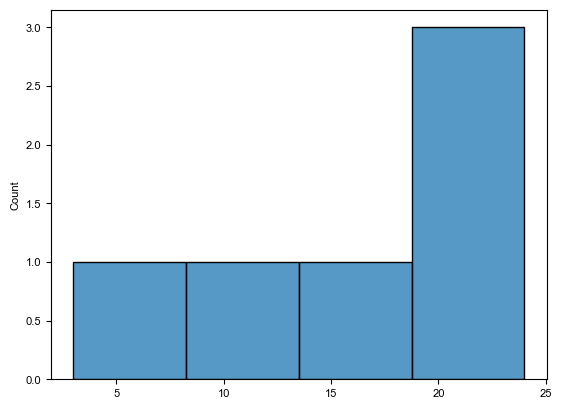

Age:
Intervention mean, std: 39.52, 10.71
Waitlist mean, std: 38.17, 10.91
t: nan, p: nan


Sex:
group   Intervention  Waitlist
sex                           
Female            56        74
Male              32        39
chi2 =  0.015268845186348044
p =  0.9016579887762945

Ethnicity:
group                         Intervention  Waitlist
eth_original                                        
Any other ethnic group                   2         2
Asian/Asian British                      5         6
Black/Black British                      5         1
Mixed/Multiple ethnic groups             3         3
White/White British                     75       101
chi2 =  4.044492677512591
p =  0.40001790791577196

Employment:
group                                               Intervention  Waitlist
employ_original                                                           
Retired                                                        1         2
Student                                               

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import numpy as np
import seaborn as sns
import bambi as bmb
from scipy import stats
from scipy.stats import chi2_contingency
import warnings
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings("ignore")



dict={'Neither successful nor unsuccessful':0,
       'Quite successful': 1,
      'Very successful': 2,
      'Quite unsuccessful': -1,
      'Very unsuccessful': -2,
     }

dir = '/Users/paul/Documents_local/rct-data/rct-2023-03/'

df = pd.read_csv(dir + 'preprocessed_data/merged.csv', delimiter=',', error_bad_lines=False)
# Get the column names starting with "spin"
# df=df[~((df['group']=='Intervention') & (df ['app_version']=='none'))]
df=df[~((df['group']=='Waitlist') & (df ['app_version']=='rct_app'))]

# Dictionary to map values
dict_expect_original = {
    'Neither successful nor unsuccessful': 0,
    'Quite successful': 1,
    'Very successful': 2,
    'Quite unsuccessful': -1,
    'Very unsuccessful': -2,
}

# Apply mapping using the dictionary
df['expect_original'] = df['expect_original'].map(dict_expect_original)

expectations=df['expect_original']
spin_columns = [col for col in df.columns if col.startswith("spin")]



# Drop rows with NaN values in spin_columns
df = df.dropna(subset=spin_columns)

import pandas as pd

# Assuming your original DataFrame is called 'df'
# and the columns to be converted are 'spintot_w8', 'spintot_w9', etc.

# Extract the subject ID column (assuming it is named 'subject_id')
subject_id = df['pid']

# Extract the group column (assuming it is named 'group')
df['group_binary']=[1 if x=='Intervention' else 0 for x in df['group']] 
group = df['group_binary']


exercises_completed = df['total_exercises_completed']
self_report_completion=df['end_original_w1']

import pandas as pd

# Your dataframe df

# Get column names starting with "end_original_w"
columns = [col for col in df.columns if col.startswith("end_original_w")]

# Filter columns for weeks 1 to 8
week_columns = [col for col in columns if int(col.split("w")[-1]) in range(1, 9)]
# Convert 'Yes' to 1 and 'No' to 0 for these columns
df[week_columns] = df[week_columns].replace({'Yes': 1, 'No': 0})

# Calculate row-wise sum for these columns
df['sum_self_reported_therapy_usage'] = df[week_columns].sum(axis=1)


individual_difference_measure='spintot' #fear of negative evaluation subscale
                                                  #could do SPIN, WSAS or any subscale of SPIN
                                                  #WSAS is significant!

# Create a new DataFrame to store the converted data
new_df = pd.DataFrame()

# Loop through each week column and perform the conversion
for week_column in df.columns:
    if week_column.startswith(individual_difference_measure):

        week = int(week_column.split('_')[1][1])  # Extract the week number from the column name
        sr_week='end_original_w{}'.format(week)

        week_data = df[[week_column]]  # Select only the week column
        week_data.columns = ['spin']  # Rename the column to 'spin'
        week_data['week'] = week  # Add a new column 'week' with the week number
        week_data['group'] = group  # Add the 'group' column to repeat the group information
        week_data['subject_id'] = subject_id
        week_data['therapy_usage']=exercises_completed
        week_data['expectation']=expectations

        # Impute missing spin ratings by prediction
        missing_mask = week_data['spin'].isnull()

        if missing_mask.any():
            # Split the data into complete and missing spin ratings

            complete_data = week_data[~missing_mask].copy()
            missing_data = week_data[missing_mask].copy()

            # Prepare the data for training the imputation model
            X_train = complete_data.drop(['spin','subject_id'], axis=1)
            y_train = complete_data['spin']
            X_test = missing_data.drop(['spin','subject_id'], axis=1)

            # Train a random forest regressor as the imputation model
            model = RandomForestRegressor()
            model.fit(X_train, y_train)

            # Predict the missing spin ratings
            imputed_values = model.predict(X_test)

            # Update the missing spin ratings in the week_data DataFrame
            week_data.loc[missing_mask, 'spin'] = imputed_values
        new_df = pd.concat([new_df, week_data])  # Append the converted data to the new DataFrame


intervention_group = df[df['group'] == 'Intervention']



# SCATTER PLOTS OF THERAPY USAGE AND DIFFERENT SYMPTOMS -- HERE WSAS
# intervention_group = df[df['group'] == 'Intervention']
# change_w1_w8=intervention_group['wsastot_w8']-intervention_group['wsastot_w0']
# intervention_group['change_symptoms']=change_w1_w8


# intervention_group_none=intervention_group[intervention_group['total_exercises_completed']<intervention_group['total_exercises_completed'].median()]
# print('\n mean sym change int group NO THERAPY: {}'.format(intervention_group_none['change_symptoms'].median()))
# intervention_group_some=intervention_group[intervention_group['total_exercises_completed']>intervention_group['total_exercises_completed'].median()]
# print('mean sym change int group SOME THERAPY: {}\n'.format(intervention_group_some['change_symptoms'].median()))

# r,p=stats.spearmanr(change_w1_w8,intervention_group['total_M2'])
# ax=sns.scatterplot(x='change_symptoms',y='total_exercises_completed',data=intervention_group)
# # plt.savefig("treatmentGroup_changeSymptoms_TotalExercisesCompleted.png",dpi=300)

# plt.show()
# print('effect of using therapy on symptom change: {}, pval: {}'.format(r,p))


# Back to Mona's script
waitlist_group = df[df['group'] == 'Waitlist']

# !update this as the trial procedes!
pp_any = df.drop(df[(df['group'] == 'Intervention') & ((df['M0_any'] == 0) | (df['M1_any']  == 0) | (df['M2_any']  == 0) | (df['M4_any']  == 0) | (df['M5_any']  == 0))].index) # users in the intervention group who didnt complete at least one exercise per module are removed
pp_none=df.drop(df[(df['group'] == 'Intervention') & ((df['M0_any'] == 1) | (df['M1_any']  == 1) | (df['M2_any']  == 1) | (df['M4_any']  == 1) | (df['M5_any']  == 1))].index) # users in the intervention group who didnt complete at least one exercise per module are removed
pp_none=pp_none[pp_none['group']=='Intervention']

print(df['M0_any'])
print(np.mean(pp_none['spintot_w0']-pp_none['spintot_w8']))
sns.histplot(pp_none['spintot_w0']-pp_none['spintot_w8'])
plt.show()
column_none_or_some=[0 if x in pp_none.pid.unique() else 0 for x in df.pid]
df['none_or_some']=column_none_or_some


pp_all = df.drop(df[(df['group'] == 'Intervention') & ((df['M0_completed'] == 0) | (df['M1_completed']  == 0) | (df['M2_completed']  == 0))].index) # users in the intervention group who didnt complete all exercises per module are removed

print('Age:')
t, p = stats.ttest_ind(df['age'][df['group'] == 'Waitlist'], df['age'][df['group'] == 'Intervention'])
intervention_mean = intervention_group['age'].mean()
intervention_std = intervention_group['age'].std()
waitlist_mean = waitlist_group['age'].mean()
waitlist_std = waitlist_group['age'].std()
print('Intervention mean, std: {:.2f}, {:.2f}'.format(intervention_mean, intervention_std))
print('Waitlist mean, std: {:.2f}, {:.2f}'.format(waitlist_mean, waitlist_std))
print('t: {:.2f}, p: {:.2f}\n'.format(t, p))

print('\nSex:')
observations = pd.crosstab(index=df["sex"], columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print(observations)
print("chi2 = ", chi2)
print("p = ", p)

print('\nEthnicity:')
observations = pd.crosstab(index=df["eth_original"], columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print(observations)
print("chi2 = ", chi2)
print("p = ", p)

print('\nEmployment:')
observations = pd.crosstab(index=df["employ_original"], columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print(observations)
print("chi2 = ", chi2)
print("p = ", p)

print('\nEducation:')
observations = pd.crosstab(index=df["edu_original"], columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print(observations)
print("chi2 = ", chi2)
print("p = ", p)

print('\nPrevious app use:')
observations = pd.crosstab(index=df["apps_original"], columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print(observations)
print("chi2 = ", chi2)
print("p = ", p)

print('\nPrevious therapy experience experience:')
observations = pd.crosstab(index=df["thpy_original"], columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print(observations)
print("chi2 = ", chi2)
print("p = ", p)

print('\nSPIN at baseline:')
dfspintest = df[['spintot_w0', 'group']]
dfspintest = dfspintest.dropna()    
t, p = stats.ttest_ind(dfspintest['spintot_w0'][dfspintest['group'] == 'Waitlist'], dfspintest['spintot_w0'][dfspintest['group'] == 'Intervention'])
intervention_mean = df['spintot_w0'][df['group'] == 'Intervention'].mean()
intervention_std = df['spintot_w0'][df['group'] == 'Intervention'].std()
waitlist_mean = df['spintot_w0'][df['group'] == 'Waitlist'].mean()
waitlist_std = df['spintot_w0'][df['group'] == 'Waitlist'].std()
print('Intervention mean, std: {:.2f}, {:.2f}'.format(intervention_mean, intervention_std))
print('Waitlist mean, std: {:.2f}, {:.2f}'.format(waitlist_mean, waitlist_std))
print('t: {:.2f}, p: {:.2f}\n'.format(t, p))



print('\nExpectation:')
observations = pd.crosstab(index=df["expect_original"], columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print(observations)
print("chi2 = ", chi2)
print("p = ", p)


plt.style.use('default')
plt.rcParams.update({'font.family':'sans-serif'})
plt.rcParams.update({'font.sans-serif':'Arial'})
plt.rcParams.update({'font.size': 8})


print('\nApp versions:')
observations = pd.crosstab(index=df["app_version"], columns=df["group"], margins=False)
print(observations)



# Fit LMM Model and Plot main effect of therapy over time versus control on SPIN

      spin  week  group                subject_id  therapy_usage  expectation
0     39.0     0      1  5bddfba7712eb800010d3a61             44          1.0
1     55.0     0      1  5b87c3f9e88caf0001b79375             13          1.0
2     52.0     0      1  62da562ad9942a440f6986c9             45          1.0
3     60.0     0      1  595ceea8dd044900012ce64a             50          1.0
4     46.0     0      1  5aafb6f2e1546900019b0772             42          0.0
...    ...   ...    ...                       ...            ...          ...
1822  31.0     8      0  63861830958b7290de6353fc              0         -1.0
1823  24.0     8      0  5f6f4ae8796bee4c3f824545              0          0.0
1824  13.0     8      0  5a55c8d276d1c60001aadcb0              0          1.0
1825  10.0     8      1  60b0f00d76201e617923f93f             37          0.0
1826  53.0     8      1  5fc63e053cf83c06341ac94a             40          1.0

[1827 rows x 6 columns]


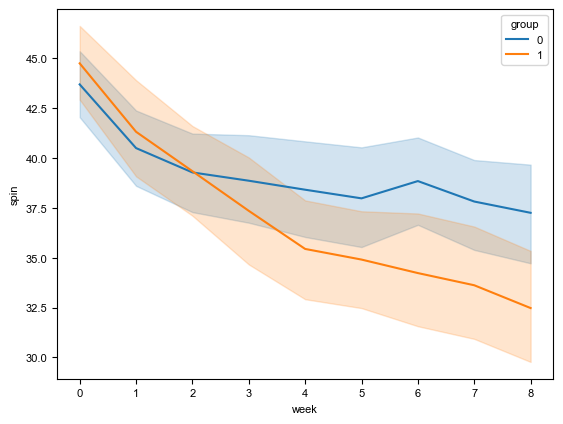

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, group, week, week:group, 1|subject_id_sigma, 1|subject_id_offset, week|subject_id_sigma, week|subject_id_offset, spin_sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 231 seconds.


             mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
week:group -0.820  0.209    -1.228     -0.406      0.004    0.003    3164.0   
week       -0.593  0.140    -0.874     -0.330      0.002    0.002    3272.0   

            ess_tail  r_hat  
week:group    4393.0    1.0  
week          4851.0    1.0  


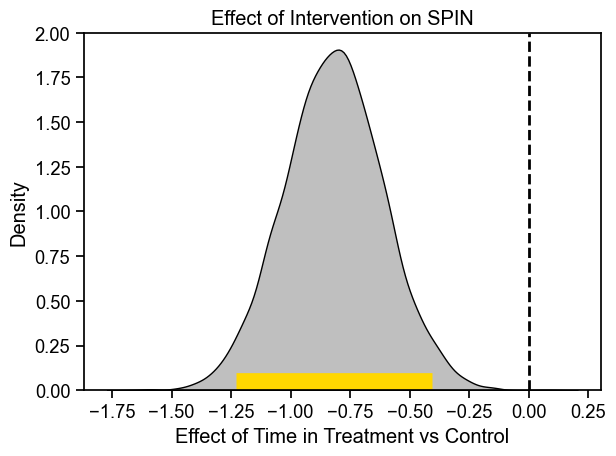

In [22]:
# Reset the index of the new DataFrame
new_df.reset_index(drop=True, inplace=True)
#LMM on key effect of therapy vs. control

ax=sns.lineplot(x='week',y='spin',hue='group',data=new_df)
plt.show()
# Note new_df starts at week 1 above
model2 = bmb.Model('spin ~ group+week+week*group+(week|subject_id)', data=new_df)
fitted2 = model2.fit(draws=2000, tune=2000,target_accept=0.95,idata_kwargs = {'log_likelihood': True})
print(az.summary(fitted2,var_names=['week:group','week'],hdi_prob=0.95))

import arviz as az
import seaborn as sns
import pandas as pd

sns.set_context("notebook", font_scale=1.2)

# assuming idata is your InferenceData object
# and 'param_name' is the name of the parameter you want to plot
param_name='week:group'

# Extract posterior
posterior = fitted2.posterior

# Convert to pandas dataframe
df_posterior = posterior[param_name].to_dataframe().reset_index()

# Drop additional hierarchical index columns produced by xarray
df_posterior = df_posterior.drop(columns=['chain', 'draw'])

# Compute 95% HDI
hdi = az.hdi(df_posterior[param_name].to_numpy(), hdi_prob=0.95)

# Plot
sns.kdeplot(data=df_posterior, fill=True,x=param_name, color='k')

# Add HDI as a horizontal line right above the x-axis
plt.hlines(y=0, xmin=hdi[0],xmax=hdi[1], linewidth=25, color='gold')

plt.xlabel('Effect of Time in Treatment vs Control')
plt.title('Effect of Intervention on SPIN')

plt.tight_layout()
plt.axvline(0, color='black', linestyle='--', linewidth=2)
plt.savefig('TreatmentEffect_onSPIN_LMM.png',dpi=300)
plt.show()


# Fit LMM model and Plot effect of objective therapy use on declines in WSAS in non-NONE group (group that lost objective therapy data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, week, therapy_usage, week:therapy_usage, 1|subject_id_sigma, 1|subject_id_offset, week|subject_id_sigma, week|subject_id_offset, spin_fne_sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 209 seconds.


                     mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
week                0.044  0.254    -0.461      0.529      0.005    0.003   
week:therapy_usage -0.019  0.008    -0.034     -0.004      0.000    0.000   

                    ess_bulk  ess_tail  r_hat  
week                  3092.0    4655.0    1.0  
week:therapy_usage    3002.0    4506.0    1.0  


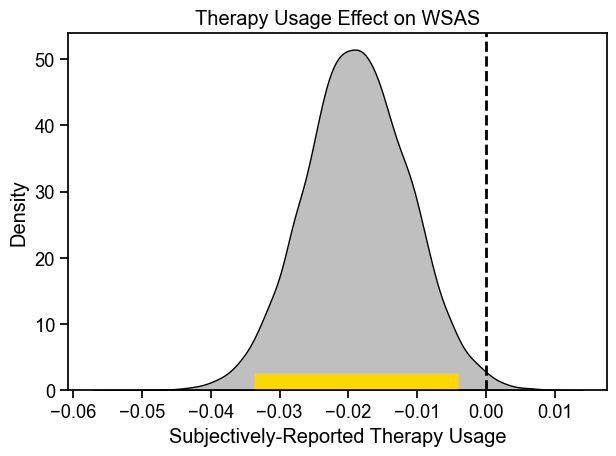

In [32]:
# Create a new DataFrame to store the converted data
df_withoutmissingobjecitvedata=df[~((df['group']=='Intervention') & (df ['app_version']=='none'))]
exercises_completed = df_withoutmissingobjecitvedata['total_exercises_completed']
new_df = pd.DataFrame()
individual_difference_measure='wsastot' #spin_fne
for week_column in df_withoutmissingobjecitvedata.columns:
    if week_column.startswith(individual_difference_measure):
        week = int(week_column.split('_')[1][1])  # Extract the week number from the column name
        week_data = df_withoutmissingobjecitvedata[[week_column]]  # Select only the week column
        week_data.columns = ['spin_fne']  # Rename the column to 'spin'
        week_data['week'] = week  # Add a new column 'week' with the week number
        week_data['group'] = group  # Add the 'group' column to repeat the group information
        week_data['subject_id'] = subject_id
        week_data['therapy_usage']=exercises_completed
        week_data['expectation']=expectations


        # Impute missing spin ratings by prediction
        missing_mask = week_data['spin_fne'].isnull()

        if missing_mask.any():
            print('here')
            # Split the data into complete and missing spin ratings

            complete_data = week_data[~missing_mask].copy()
            missing_data = week_data[missing_mask].copy()

            # Prepare the data for training the imputation model
            X_train = complete_data.drop(['spin_fne','subject_id'], axis=1)
            y_train = complete_data['spin_fne']
            X_test = missing_data.drop(['spin_fne','subject_id'], axis=1)

            # Train a random forest regressor as the imputation model
            model = RandomForestRegressor()
            model.fit(X_train, y_train)

            # Predict the missing spin ratings
            imputed_values = model.predict(X_test)

            # Update the missing spin ratings in the week_data DataFrame
            week_data.loc[missing_mask, 'spin_fne'] = imputed_values
        new_df = pd.concat([new_df, week_data])  # Append the converted data to the new DataFrame


# Reset the index of the new DataFrame
new_df.reset_index(drop=True, inplace=True)
new_df=new_df[new_df['group']==1] # Just intervention group
# note in the below model on OBJECTIVE therapy usage data, it takes the total, which is one score per subject
model3 = bmb.Model('spin_fne ~ week+therapy_usage+week*therapy_usage+(week|subject_id)', data=new_df)
fitted3 = model3.fit(draws=2000, tune=2000,target_accept=0.95,idata_kwargs = {'log_likelihood': True})

print(az.summary(fitted3,var_names=['week','week:therapy_usage'],hdi_prob=0.95))

import arviz as az
import seaborn as sns
import pandas as pd

sns.set_context("notebook", font_scale=1.2)

# assuming idata is your InferenceData object
# and 'param_name' is the name of the parameter you want to plot
param_name='week:therapy_usage'

# Extract posterior
posterior = fitted3.posterior

# Convert to pandas dataframe
df_posterior = posterior[param_name].to_dataframe().reset_index()

# Drop additional hierarchical index columns produced by xarray
df_posterior = df_posterior.drop(columns=['chain', 'draw'])

# Compute 95% HDI
hdi = az.hdi(df_posterior[param_name].to_numpy(), hdi_prob=0.95)

# Plot
sns.kdeplot(data=df_posterior, fill=True,x=param_name, color='k')

# Add HDI as a horizontal line right above the x-axis
plt.hlines(y=0, xmin=hdi[0],xmax=hdi[1], linewidth=25, color='gold')

plt.xlabel('Subjectively-Reported Therapy Usage')
plt.title('Therapy Usage Effect on WSAS')

plt.tight_layout()
plt.axvline(0, color='black', linestyle='--', linewidth=2)
plt.savefig('ObjectiveTherapyUsage_WSAS.png',dpi=300)
plt.show()

# Fit LMM model and Plot effect of self-reported therapy usage on SPIN-FNE in treatment group

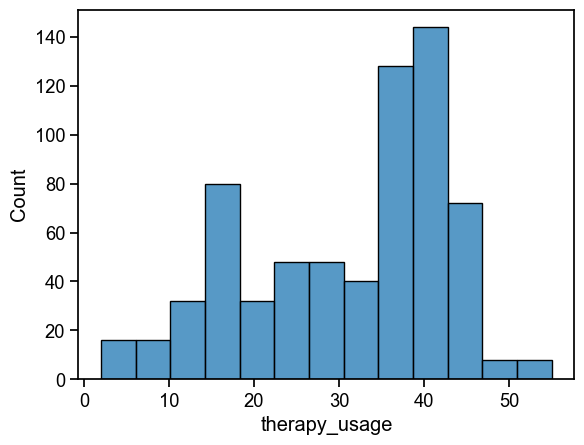

fear of negative evaluation


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, week, self_reported_therapy_usage, week:self_reported_therapy_usage, 1|subject_id_sigma, 1|subject_id_offset, week|subject_id_sigma, week|subject_id_offset, self_reported_therapy_usage|subject_id_sigma, self_reported_therapy_usage|subject_id_offset, week:self_reported_therapy_usage|subject_id_sigma, week:self_reported_therapy_usage|subject_id_offset, spin_fne_sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 246 seconds.


                                   mean     sd  hdi_2.5%  hdi_97.5%  \
week                             -0.385  0.101    -0.586     -0.184   
self_reported_therapy_usage       0.080  0.552    -1.005      1.143   
week:self_reported_therapy_usage -0.217  0.108    -0.430     -0.009   

                                  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
week                                  0.002    0.001    2605.0    3870.0   
self_reported_therapy_usage           0.009    0.006    4121.0    5538.0   
week:self_reported_therapy_usage      0.002    0.001    4080.0    5457.0   

                                  r_hat  
week                                1.0  
self_reported_therapy_usage         1.0  
week:self_reported_therapy_usage    1.0  


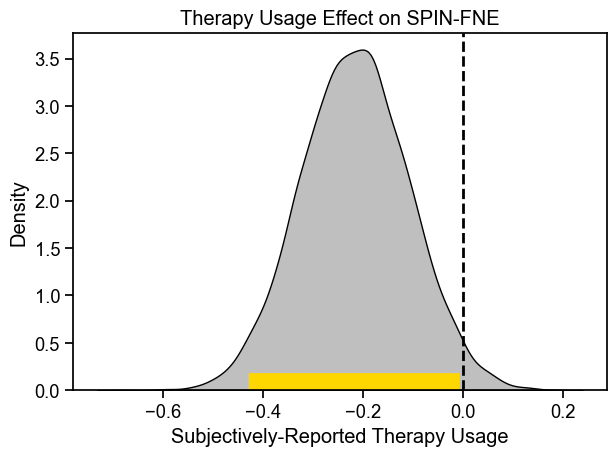

In [35]:


# Create a new DataFrame to store the converted data
new_df = pd.DataFrame()
individual_difference_measure='negative_subscale'
for week_column in df.columns:
    if week_column.startswith(individual_difference_measure):
        week = int(week_column.split('_')[2][1])  # Extract the week number from the column name
        if week>0: # self-reported therapy usage starts at week 1, for other effects, remove this!
            sr_week='end_original_w{}'.format(week)

            week_data = df[[week_column]]  # Select only the week column
            week_data.columns = ['spin_fne']  # Rename the column to 'spin'
            week_data['week'] = week  # Add a new column 'week' with the week number
            week_data['self_reported_therapy_usage']=df[[sr_week]]
            week_data['group'] = group  # Add the 'group' column to repeat the group information
            week_data['subject_id'] = subject_id
            week_data['therapy_usage']=exercises_completed
            week_data['expectation']=expectations


            # Impute missing spin ratings by prediction
            missing_mask = week_data['spin_fne'].isnull()

            if missing_mask.any():
                print('here')
                # Split the data into complete and missing spin ratings

                complete_data = week_data[~missing_mask].copy()
                missing_data = week_data[missing_mask].copy()

                # Prepare the data for training the imputation model
                X_train = complete_data.drop(['spin_fne','subject_id'], axis=1)
                y_train = complete_data['spin_fne']
                X_test = missing_data.drop(['spin_fne','subject_id'], axis=1)

                # Train a random forest regressor as the imputation model
                model = RandomForestRegressor()
                model.fit(X_train, y_train)

                # Predict the missing spin ratings
                imputed_values = model.predict(X_test)

                # Update the missing spin ratings in the week_data DataFrame
                week_data.loc[missing_mask, 'spin_fne'] = imputed_values
            new_df = pd.concat([new_df, week_data])  # Append the converted data to the new DataFrame


# Reset the index of the new DataFrame
new_df.reset_index(drop=True, inplace=True)

#create inveternion group and plot
intervention_group = new_df[new_df['group'] == 1]
sns.histplot(intervention_group['therapy_usage'])
plt.show()

print('fear of negative evaluation')
model5 = bmb.Model('spin_fne ~ week+self_reported_therapy_usage+week*self_reported_therapy_usage+(week+self_reported_therapy_usage+week*self_reported_therapy_usage|subject_id)', data=intervention_group)
fitted5 = model5.fit(draws=2000, tune=2000,target_accept=0.95,idata_kwargs = {'log_likelihood': True})
print(az.summary(fitted5,var_names=['week','self_reported_therapy_usage','week:self_reported_therapy_usage',],hdi_prob=0.95))


import arviz as az
import seaborn as sns
import pandas as pd

sns.set_context("notebook", font_scale=1.2)

# assuming idata is your InferenceData object
# and 'param_name' is the name of the parameter you want to plot
param_name='week:self_reported_therapy_usage'

# Extract posterior
posterior = fitted5.posterior

# Convert to pandas dataframe
df_posterior = posterior[param_name].to_dataframe().reset_index()

# Drop additional hierarchical index columns produced by xarray
df_posterior = df_posterior.drop(columns=['chain', 'draw'])

# Compute 95% HDI
hdi = az.hdi(df_posterior[param_name].to_numpy(), hdi_prob=0.95)

# Plot
sns.kdeplot(data=df_posterior, fill=True,x=param_name, color='k')

# Add HDI as a horizontal line right above the x-axis
plt.hlines(y=0, xmin=hdi[0],xmax=hdi[1], linewidth=25, color='gold')

plt.xlabel('Subjectively-Reported Therapy Usage')
plt.title('Therapy Usage Effect on SPIN-FNE')

plt.tight_layout()
plt.axvline(0, color='black', linestyle='--', linewidth=2)
plt.savefig('subjectivelyReported_therapyUsage_SPIN_FNE.png',dpi=300)
plt.show()

# Adverse events

### The code extracts information on adverse events reported by the intervention and the waitlist control group and exports it to CSV files for further analysis. The code loops through CSV files in a directory for each group and week, and counts the number of participants who reported any new effects in the past week. The data is then exported to a CSV file. It is important to note that the questions that were asked are different between the groups, results can therefore not be direclty compared!
### Intervention group: 'Have you experienced any negative effects from using the Alena app?': 'advapp_original_w'+str(i)
### Waitlist group: 'Have you experienced any negative effects from taking part in this study? ': 'advall_original_w'+str(i),

In [36]:
# Create two separate dataframes for the intervention and waitlist groups. The two groups were asked different questions, results can therefore not be direclty compared!
# Intervention group: 'Have you experienced any negative effects from using the Alena app?': 'advapp_original_w'+str(i)
# Waitlist group: 'Have you experienced any negative effects from taking part in this study? ': 'advall_original_w'+str(i),
df = pd.read_csv(dir + 'preprocessed_data/merged.csv', delimiter=',', error_bad_lines=False)

# create a dataframe for the intervention group                            
adv_df = pd.DataFrame(columns=['group','pid', 'week','response','severity','description'])
# print('\nIntervention group:')

# for week in range(1,11):
#     col_name = 'advapp_original_w' + str(week)
#     if col_name in df.columns:  # Check if column exists
#         count = 0

#         # count the number of "Yes" or "I'm not sure" in the column "Have you experienced any new, serious negative health effects in the past week?"
#         count = 0
#         for index, row in df.iterrows():
#             if row[col_name] in ['Yes', "I'm not sure"]:
#                 count += 1
#                 pid = row['pid']
#                 descr = row['advapp_qual_w' + str(week)]
#                 severity = row['advapp_sev_w' + str(week)]
#                 adv_df = adv_df.append({'group': row['group'], 'pid': pid, 'week': week, 'response': row[col_name], 'severity': severity,'description': descr}, ignore_index=True)
#         print('Week', week, ':', count)

# adv_df.drop_duplicates(inplace=True)
# adv_df.to_csv('adverse_outcomes_intervention.csv')

# print('\nWaitlist group:')
# # create a dataframe for the waitlist group
# adv_df = pd.DataFrame(columns=['group','pid', 'week','response','severity','description'])
# for week in range(1,11):
#     col_name = 'advall_original_w' + str(week)
#     if col_name in df.columns:  # Check if column exists
#         count = 0

#         # count the number of "Yes" or "I'm not sure" in the column "Have you experienced any new, serious negative health effects in the past week?"
#         count = 0
#         for index, row in df.iterrows():
#             if row[col_name] in ['Yes', "I'm not sure"]:
#                 count += 1
#                 pid = row['pid']
#                 descr = row['advall_original_w' + str(week)]
#                 severity = row['advall_original_w' + str(week)]
#                 adv_df = adv_df.append({'group': row['group'], 'pid': pid, 'week': week, 'response': row[col_name], 'severity': severity,'description': descr}, ignore_index=True)
#         print('Week', week, ':', count)

# adv_df.drop_duplicates(inplace=True)
# adv_df.to_csv('adverse_outcomes_waitlist.csv')

# create a dataframe for the waitlist group
adv_df = pd.DataFrame(columns=['group','pid', 'week','response','severity','related to study','description'])
for week in range(1,11):
    col_name = 'advhealth_original_w' + str(week)
    if col_name in df.columns:  # Check if column exists

        # count the number of "Yes" or "I'm not sure" in the column "Have you experienced any new, serious negative health effects in the past week?"
        count = 0
        for index, row in df.iterrows():
            if row[col_name] in ['Yes', "I'm not sure"]:
                count += 1
                pid = row['pid']
                descr = row['advhealth_qual_w' + str(week)]
                severity = row['advhealth_sev_w' + str(week)]
                if week > 4:
                    study = row['advhealth_study_w' + str(week)]
                else:
                    study = ''
                adv_df = adv_df.append({'group': row['group'], 'pid': pid, 'week': week, 'response': row[col_name], 'severity': severity,'related to study': study, 'description': descr}, ignore_index=True)
        print('Week', week, ':', count)
        
    

adv_df.drop_duplicates(inplace=True)
adv_df.to_csv('adverse_health_effects.csv')
# count the total number of entries for each group
group_counts = adv_df['group'].value_counts()

# count the number of unique pids in each group
unique_pids = adv_df.groupby('group')['pid'].nunique()

# print the results
print('\nTotal number of entries for each group:')
print(group_counts)

print('\nNumber of unique pids in each group:')
print(unique_pids)

print('\nDifference total number of users:')
obs = [[26, 17], [124, 125]]
chi2, p, dof, expected = chi2_contingency(obs)

print("Chi-squared statistic:", chi2)
print("p-value:", p)





Week 4 : 18
Week 5 : 13
Week 6 : 12
Week 7 : 14
Week 8 : 12

Total number of entries for each group:
Waitlist        38
Intervention    31
Name: group, dtype: int64

Number of unique pids in each group:
group
Intervention    20
Waitlist        27
Name: pid, dtype: int64

Difference total number of users:
Chi-squared statistic: 1.27014739600393
p-value: 0.2597390303335587


# Questionnaire completion rates by week

### The code calculates the percentage of missing values at each time point for each group and performs a chi-square test to determine if there is a significant difference in the missing values between groups.




########################

Week 0
group       Intervention  Waitlist
spintot_w0                        
False                124       125
chi2 = 0.0
p = 1.0



########################

Week 1
group       Intervention  Waitlist
spintot_w1                        
False                106       123
True                  18         2
chi2 = 12.364087283420202
p = 0.0004376714753904672



########################

Week 2
group       Intervention  Waitlist
spintot_w2                        
False                109       125
True                  15         0
chi2 = 14.024415260545906
p = 0.0001804522787211726



########################

Week 3
group       Intervention  Waitlist
spintot_w3                        
False                107       124
True                  17         1
chi2 = 13.6044284666946
p = 0.00022565258938423452



########################

Week 4
group       Intervention  Waitlist
spintot_w4                        
False                107       124
True            

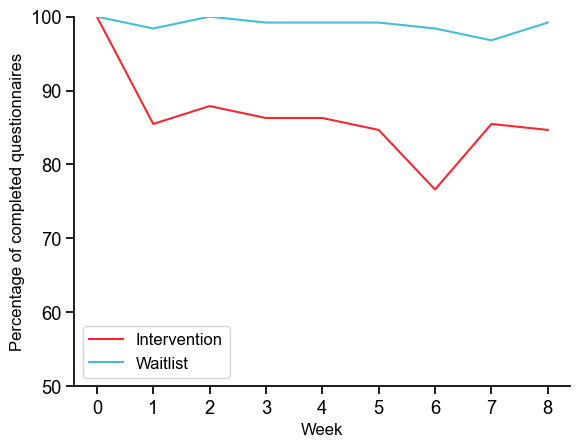

In [46]:
import pandas as pd
from scipy.stats import ttest_ind, chi2_contingency

# Define a function to compute the percentage of missing values
def nonmissing_percentage(column):
    return 100 - (column.isna().sum() / len(column) * 100)

# Test for statistical significance using a chi-square test
p_values = []
columns_of_interest = []

# Iterate over the weeks and perform the calculations
for week in range(0, 10):  # List of weeks to check
    column_name = "spintot_w" + str(week)
    
    if column_name in df.columns:
        columns_of_interest.append(column_name)
        print('\n\n\n########################\n\nWeek', week)
        missing_data = df[column_name].isnull()
        observations = pd.crosstab(index=missing_data, columns=df["group"], margins=False)
        chi2, p, dof, ex = chi2_contingency(observations)
        print(observations)
        print("chi2 =", chi2)
        print("p =", p)
        p_values.append(p)
        
# Calculate percentage of complete data per group
group_percentage = df.groupby('group')[columns_of_interest].apply(lambda x: (~x.isnull()).mean()) * 100

# Extract the weeks from column names
weeks = [int(col.split('_')[1][1:]) for col in columns_of_interest]

# Create a line plot# Define line colors
line_colors = ["#f42831", "#44bed8"]

# Create a line plot
fig, ax = plt.subplots()
for i, group in enumerate(group_percentage.index):
    ax.plot(weeks, group_percentage.loc[group], label=group, color=line_colors[i])


ax.set_xlabel('Week', fontsize=12)
ax.set_ylabel('Percentage of completed questionnaires', fontsize=12)
ax.set_ylim(50, 100)  # Set y-axis limits
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(weeks, weeks)
# Move legend to bottom left corner
ax.legend(loc='lower left', bbox_to_anchor=(0, 0), fontsize=12)
plt.show()




# Acceptability

### This analysis examines the acceptability of the intervention. The first section of the code compares the reported completion rates of the intervention group at different time points. The second section of the code plots a histogram showing the number of completed modules by participants at the end of the four-week intervention.

### The remaining sections of the code examine the satisfaction, helpfulness, ease of use, recommendation, and completion rates of the intervention program. For each of these variables, the code creates a plot that displays the percentage of responders who fall into different response categories at different time points. The plots are saved to an output file called 'acceptability.eps'.

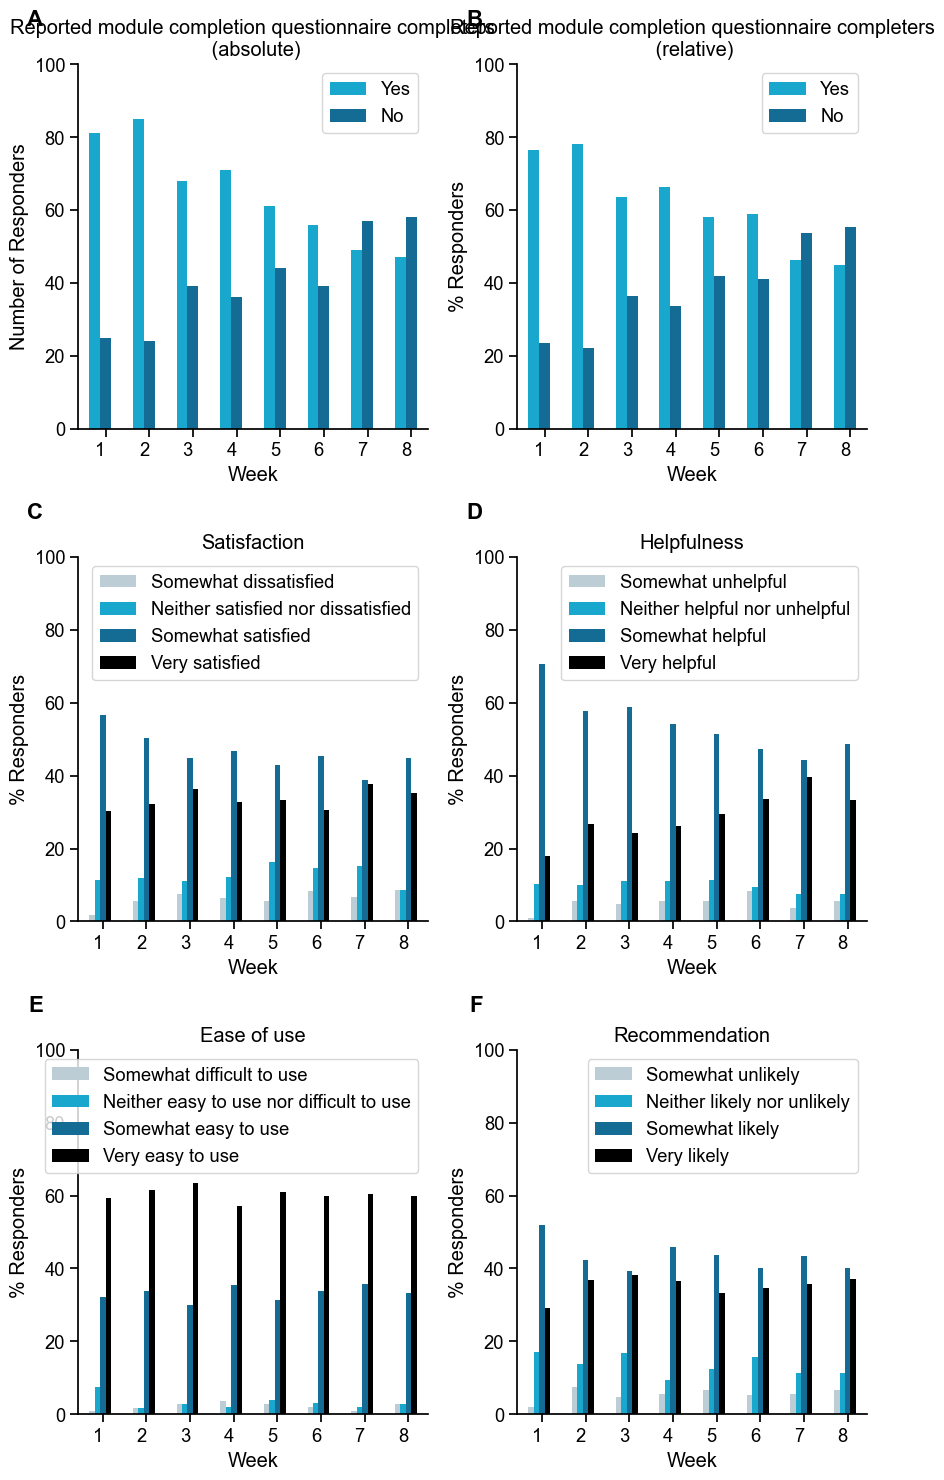

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [48]:
# Acceptability data
intervention_group=df[df['group']=='Intervention']
import statsmodels.api as sm
import statsmodels.formula.api as smf

title = 'Reported module completion questionnaire completers\n'
variables = ['end_original_w']
order = {'end_original_w': ['Yes','No']}

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,15))

columns_of_interest = []
# Iterate over the weeks and perform the calculations
for week in range(0, 10):  # List of weeks to check
    column_name = "end_original_w" + str(week)
    
    if column_name in df.columns:
        columns_of_interest.append(column_name)
        
# Extract the weeks from column names
weeks = [int(col.split('_')[2][1:]) for col in columns_of_interest]

satis = intervention_group[columns_of_interest]
satis = pd.melt(satis, value_vars = columns_of_interest)
satis = satis.dropna() # drop missing values - if this line is commented out, the missing values will be counted as "No"

freq_abs = pd.crosstab(satis.variable, satis.value)
freq_abs = freq_abs[order['end_original_w']]

ax = fig.add_subplot(3,2,1)
ax.text(-0.1, 1.15, 'A', transform=ax.transAxes,
  fontsize=16, fontweight='bold', va='top', ha='right')

g = freq_abs.plot(kind='bar', color=["#19A7CE","#146C94", "#000000"], ax = ax)
g.set(ylim = (0,100), xlabel = 'Week', ylabel = 'Number of Responders', title = title + ' (absolute)')
 # Get the width of each bar
bar_width = g.patches[0].get_width()

# Set the xticks to the center of each bar
plt.xticks([i + bar_width/2 for i in range(len(weeks))], weeks)
plt.xticks(rotation=360, ha='right')
ax.spines[['right', 'top']].set_visible(False)
ax.legend(loc=0, title='')

# Percentage
ax = fig.add_subplot(3,2,2)
ax.text(-0.1, 1.15, 'B', transform=ax.transAxes,
  fontsize=16, fontweight='bold', va='top', ha='right')

freq = pd.crosstab(satis.variable, satis.value, normalize='index')*100
freq = freq[order['end_original_w']]

g = freq.plot(kind='bar', color=["#19A7CE","#146C94", "#000000"], ax = ax)
g.set(ylim = (0,100), xlabel = 'Week', ylabel = '% Responders', title = title + ' (relative)')
plt.xticks([i + bar_width/2 for i in range(len(weeks))], weeks)
plt.xticks(rotation=360, ha='right')
ax.spines[['right', 'top']].set_visible(False)
ax.legend(loc=0, title='')

title = ['Satisfaction', 'Helpfulness', 'Ease of use', 'Recommendation', 'Completion']
variables = ['satis_original_w', 'help_original_w','easy_original_w','recc_original_w', 'end_original_w']

order = {'satis_original_w': ['Somewhat dissatisfied','Neither satisfied nor dissatisfied','Somewhat satisfied','Very satisfied'],
'help_original_w': ['Somewhat unhelpful','Neither helpful nor unhelpful','Somewhat helpful','Very helpful'],
'recc_original_w': ['Somewhat unlikely','Neither likely nor unlikely','Somewhat likely','Very likely'],
'easy_original_w': ['Somewhat difficult to use','Neither easy to use nor difficult to use','Somewhat easy to use','Very easy to use'],
'end_original_w': ['Yes','No']}

import matplotlib.pyplot as plt

for i, label in enumerate(('C', 'D', 'E', 'F')):
    vix = variables[i]

    columns_of_interest = []
    # Iterate over the weeks and perform the calculations
    for week in range(0, 10):  # List of weeks to check
        column_name = vix + str(week)
        
        if column_name in df.columns:
            columns_of_interest.append(column_name)

    satis = intervention_group[columns_of_interest]
    satis = pd.melt(satis, value_vars = columns_of_interest)
    freq = pd.crosstab(satis.variable, satis.value, normalize='index')*100
    freq = freq[order[vix]]

    ax = fig.add_subplot(3,2,i+3)
    ax.text(-0.1, 1.15, label, transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

    g = freq.plot(kind='bar', color=["#BDCDD6", "#19A7CE","#146C94", "#000000"], ax = ax)
    g.set(ylim = (0,100), xlabel = 'Week', ylabel = '% Responders', title = title[i])
    plt.xticks(rotation=360, ha='right')
    ax.spines[['right', 'top']].set_visible(False)
    ax.legend(loc=0, title='')
    # Get the width of each bar
    bar_width = g.patches[0].get_width()

    # Set the xticks to the center of each bar
    plt.xticks([i + bar_width/2 for i in range(len(weeks))], weeks)

plt.tight_layout()
    
plt.show()
fig.savefig('figures/acceptability.eps', transparent=False)


# Efficacy

### This code visualizes the results of the RCT in terms of efficacy. The code first performs an intention-to-treat analysis on SPIN and WSAS scores, which includes all randomized participants regardless of adherence to the intervention. The lines represent mean and standard errors. The intention-to-treat analysis is followed by a per-protocol analysis, which includes only participants who completed the intervention. The figure is then saved as an eps file.

age            -0.029838
wsas1_w0       -0.011592
wsas2_w0        0.081783
wsas3_w0       -0.085208
wsas4_w0        0.047123
                  ...   
total_M4        0.038607
M5_completed    0.011592
M5_any          0.091878
total_M5        0.011678
full_change     1.000000
Name: full_change, Length: 140, dtype: float64


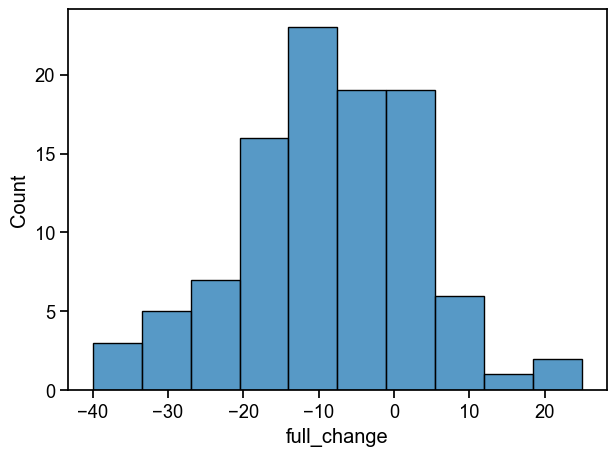


adverse events intervention:
['5b87c3f9e88caf0001b79375' '56c393c495cf7f000b956b25'
 '6271219c2f0fd73e4d217a77' '641379405684937e6fad9f1b'
 '62b182ba39468032223841bb' '5f0874db34894f07bd04f436'
 '63d190d52bb71e0e81d868f2' '5d1905fe4d7eea00170c3f28'
 '5f2afec0781f2848ac688140' '5fc63e053cf83c06341ac94a'
 '5bddfba7712eb800010d3a61' '5f85f0cab3f4e20ebf578203'
 '636928ef51cdaf360bebba1e' '623478b74666adc4ae9be6ab'
 '59839cb9554956000142d95f' '62a3b97d41ae082b602e815b'
 '5cf03df5f8188000013126aa' '56b8ad1be1d0a2000c154093'
 '5d82034b49f7b600197e5315' '56fbbcd14aaa50000da05e80']

extreme worsening of symptoms intervention:
['62b1eaacbc6e41266c8c35f1' '622e73ee8e552144c702f353'
 '5f28196752b92a0a83d7a9db' '5c462f70f5bbb70001b2f902'
 '641379405684937e6fad9f1b' '5c897696146e370001e063c9'
 '56fbbcd14aaa50000da05e80' '570ffae3736f6a00125577c5'
 '5f99104474aa880009b64318']
number of worsening symptoms that had adverse events: 4


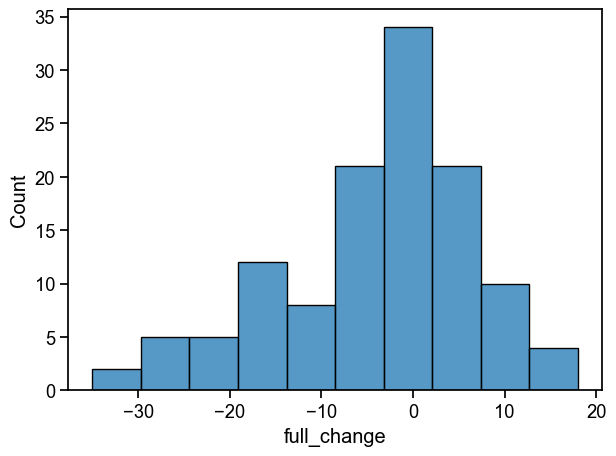


number subjects who completed at least 1 module: 54


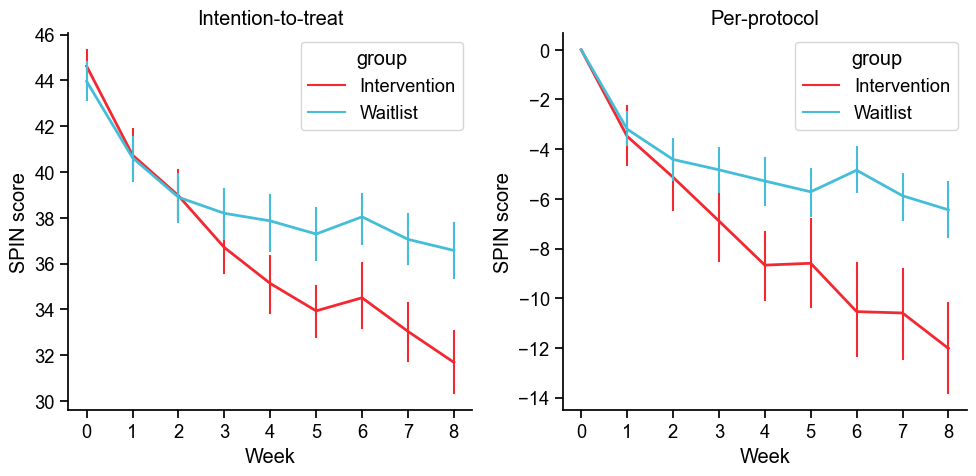

In [49]:
import seaborn as sns

#Intention-to-treat analysis
df = pd.read_csv(dir + 'preprocessed_data/merged.csv', delimiter=',', error_bad_lines=False)

columns_of_interest = ['group']

# Iterate over the weeks and perform the calculations
for week in range(0, 10):  # List of weeks to check
    column_name = "spintot_w" + str(week)
    
    if column_name in df.columns:
        columns_of_interest.append(column_name)


spin = df[columns_of_interest]
spin_final_week=df[df['group']=="Intervention"]
spin_final_week['full_change']=spin_final_week["spintot_w8"]-spin_final_week["spintot_w1"]
print(spin_final_week.corr(method='spearman')['full_change'])

spin_final_week.corr(method='spearman')['full_change'].to_csv('correlations_rank_with_symptomchange.csv')
spin_final_week.corr(method='pearson')['full_change'].to_csv('correlations_pearson_with_symptomchange.csv')

ax=sns.histplot(x='full_change',data=spin_final_week)
plt.tight_layout()
plt.savefig("teatmentgroup_week8dropinSPINfromBaseline.png",dpi=300)
plt.show()

print('\nadverse events intervention:')
adv_int=adv_df[adv_df['group']=='Intervention'].pid.unique()
print(adv_df[adv_df['group']=='Intervention'].pid.unique())
print('\nextreme worsening of symptoms intervention:')
print(spin_final_week[spin_final_week['full_change']>5].pid.unique())
worse_int=spin_final_week[spin_final_week['full_change']>0].pid.unique()
same=[sub for sub in worse_int if sub in adv_int]
print('number of worsening symptoms that had adverse events: {}'.format(len(same)))
worse_ints=spin_final_week[spin_final_week['full_change']>0]

worse_ints.to_csv('SPIN_worsened_intervention.csv')
too_much_improvement=spin_final_week[spin_final_week['full_change']<-29]
too_much_improvement.to_csv('SPIN_tooMuchImprovement_intervention.csv')

spin_final_week=spin[spin['group']=="Waitlist"]
spin_final_week['full_change']=spin_final_week["spintot_w8"]-spin_final_week["spintot_w1"]
ax=sns.histplot(x='full_change',data=spin_final_week)
plt.tight_layout()
plt.savefig("waitlistgroup_week8dropinSPINfromBaseline.png",dpi=300)
plt.show()
# spin.iloc[:, 1:] = spin.iloc[:, 1:].sub(spin["spintot_w0"], axis=0)
spin_melted = spin.melt(id_vars = 'group', var_name="timepoint", value_name="SPIN score")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
g = sns.lineplot(data=spin_melted, x = 'timepoint', y = 'SPIN score', hue = 'group', 
                err_style="bars", ci=68, palette=["#f42831", "#44bed8"], linewidth=2, ax = ax1)
g.set(xticklabels = ['0','1','2','3','4','5',"6",'7','8'], xlabel = 'Week', title='Intention-to-treat')
ax1.spines[['right', 'top']].set_visible(False)


# Per-protocol analysis
# Remove users who did not complete the interventions
spin = pp_any[columns_of_interest]
# spin_final_week=spin[spin['group']=="Intervention"]
# spin_final_week=spin_final_week["spintot_w8"]-spin_final_week["spintot_w1"]
# ax=sns.histplot(spin_final_week)
# plt.show()
print('')
pp_any_treatment=pp_any[pp_any['group']=='Intervention']
print('number subjects who completed at least 1 module: {}'.format(len(pp_any_treatment.pid.unique())))
spin.iloc[:, 1:] = spin.iloc[:, 1:].sub(spin["spintot_w0"], axis=0)
spin_melted = spin.melt(id_vars = 'group', var_name="timepoint", value_name="SPIN score")

g = sns.lineplot(data=spin_melted, x = 'timepoint', y = 'SPIN score', hue = 'group', 
                err_style="bars", ci=68, palette=["#f42831", "#44bed8"], linewidth=2, ax = ax2)
ax2.spines[['right', 'top']].set_visible(False)
g.set(xticklabels = ['0','1','2','3','4','5',"6",'7','8'], xlabel = 'Week', title='Per-protocol')


plt.tight_layout()
plt.savefig('efficacy_spin_completed_all_modules_atleastonce.png',dpi=300)
plt.show()


ITT - Number of people in Waitlist group:  125
ITT - Number of people in Intervention group:  124
PP - Number of people in Waitlist group:  113
PP - Number of people in Intervention group:  54


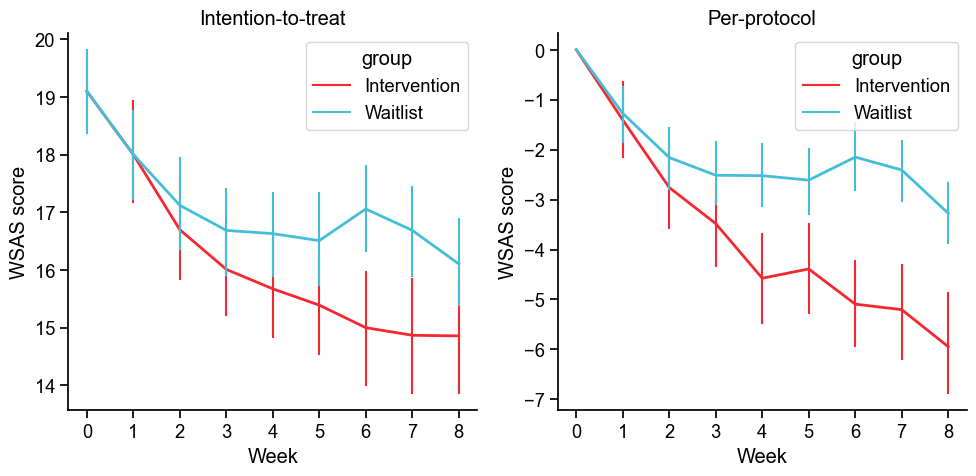

In [53]:
# Intention-to-treat analysis
columns_of_interest = ['group']

# Iterate over the weeks and perform the calculations
for week in range(0, 10):  # List of weeks to check
    column_name = "wsastot_w" + str(week)  # Change 'spintot_w' to 'wsastot_w'
    
    if column_name in df.columns:
        columns_of_interest.append(column_name)
        
wsas = df[columns_of_interest]  # Change 'spin' to 'wsas'
wsas_melted = wsas.melt(id_vars='group', var_name="timepoint", value_name="WSAS score")  # Change 'SPIN' to 'WSAS'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
g = sns.lineplot(data=wsas_melted, x='timepoint', y='WSAS score', hue='group',  # Change 'SPIN' to 'WSAS'
                err_style="bars", ci=68, palette=["#f42831", "#44bed8"], linewidth=2, ax=ax1)
g.set(xticklabels=['0', '1', '2', '3', '4', '5', "6", '7', '8'], xlabel='Week',
      title='Intention-to-treat')
ax1.spines[['right', 'top']].set_visible(False)

waitlist_count = df['group'].value_counts()['Waitlist']
intervention_count = df['group'].value_counts()['Intervention']

# Print the results
print("ITT - Number of people in Waitlist group: ", waitlist_count)
print("ITT - Number of people in Intervention group: ", intervention_count)

# Per-protocol analysis
wsas = pp_any[columns_of_interest]  # Change 'spin' to 'wsas'
wsas.iloc[:, 1:] = wsas.iloc[:, 1:].sub(wsas["wsastot_w0"], axis=0)  # Change 'spintot_w0' to 'wsastot_w0'
wsas_melted = wsas.melt(id_vars='group', var_name="timepoint", value_name="WSAS score")  # Change 'SPIN' to 'WSAS'

g = sns.lineplot(data=wsas_melted, x='timepoint', y='WSAS score', hue='group',  # Change 'SPIN' to 'WSAS'
                err_style="bars", ci=68, palette=["#f42831", "#44bed8"], linewidth=2, ax=ax2)
ax2.spines[['right', 'top']].set_visible(False)
g.set(xticklabels=['0', '1', '2', '3', '4', '5', "6", '7', '8'], xlabel='Week', title='Per-protocol')

waitlist_count = pp_any['group'].value_counts()['Waitlist']
intervention_count = pp_any['group'].value_counts()['Intervention']

# Print the results
print("PP - Number of people in Waitlist group: ", waitlist_count)
print("PP - Number of people in Intervention group: ", intervention_count)

plt.tight_layout()
plt.show()


# Change in SPIN and WSAS in an intention-to-treat sample by week

### Regression analyses are performed on the data separately for each time point. Each iteration of the loop predicts SPIN/WSAS at the current time point, and includes 'group', baseline scores and 'age' as regressors. The analysis is done under an intention-to-treat framework, which means that all participants are analyzed according to the group to which they were randomized, regardless of whether or not they received the intervention.


In [51]:
# Regression analyses, intention-to-treat, SPIN
import statsmodels.api as sm

print('\n\n\n########################################################################\nSPIN ')
print('########################################################################')
 
# Iterate over the weeks and perform the calculations
for week in range(1, 10):  # List of weeks to check
    column_name = "spintot_w" + str(week)
    
    if column_name in df.columns:
        columns_of_interest.append(column_name)

        d = df[['group','spintot_w0','age',column_name]]

        just_dummies = pd.get_dummies(d['group'])
        step1 = pd.concat([d,just_dummies], axis = 1)

        result = sm.OLS(step1[column_name], sm.add_constant(step1[['spintot_w0', 'Intervention','age']]), missing='drop').fit()
        print('\n\n\n########################\n\nWeek '+ column_name[-1])
        print (result.summary())

df['spin_change'] = (df['spintot_w0'] - df[columns_of_interest[-1]])
pp_any['spin_change'] = (pp_any['spintot_w0'] - pp_any[columns_of_interest[-1]])
pp_all['spin_change'] = (pp_all['spintot_w0'] - pp_all[columns_of_interest[-1]])

print('\n\n\n########################################################################\nWSAS ')
print('########################################################################')
        
# Iterate over the weeks and perform the calculations
for week in range(1, 10):  # List of weeks to check
    column_name = "wsastot_w" + str(week)
    
    if column_name in df.columns:
        columns_of_interest.append(column_name)

        d = df[['group','wsastot_w0','age',column_name]]

        just_dummies = pd.get_dummies(d['group'])
        step1 = pd.concat([d,just_dummies], axis = 1)

        result = sm.OLS(step1[column_name], sm.add_constant(step1[['wsastot_w0', 'Intervention','age']]), missing='drop').fit()
        print('\n\n\n########################\n\nWeek '+ column_name[-1])
        print (result.summary())





########################################################################
SPIN 
########################################################################



########################

Week 1
                            OLS Regression Results                            
Dep. Variable:             spintot_w1   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     58.04
Date:                Thu, 22 Jun 2023   Prob (F-statistic):           9.06e-28
Time:                        10:47:27   Log-Likelihood:                -792.68
No. Observations:                 227   AIC:                             1593.
Df Residuals:                     223   BIC:                             1607.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   




########################

Week 8
                            OLS Regression Results                            
Dep. Variable:             wsastot_w8   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     51.32
Date:                Thu, 22 Jun 2023   Prob (F-statistic):           2.90e-25
Time:                        10:47:27   Log-Likelihood:                -767.16
No. Observations:                 227   AIC:                             1542.
Df Residuals:                     223   BIC:                             1556.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const       

# Change in SPIN and WSAS in a per-protocol sample by week

### The code performs regression analyses for per-protocol analysis on the SPIN and WSAS data, i.e only participants in the intervention group are included who completed all therapy modules. Regression analyses are performed on the data separately for each time point. Each iteration of the loop predicts SPIN and WSAS at the current time point, and includes 'group', baseline score and 'age' as regressors. 

In [52]:
# Regression analyses, per-protocol, SPIN
import statsmodels.api as sm

print('\n\n\n########################################################################\nSPIN')
print('########################################################################')
 

# Iterate over the weeks and perform the calculations
for week in range(1, 10):  # List of weeks to check
    column_name = "spintot_w" + str(week)
    
    if column_name in pp_any.columns:
        columns_of_interest.append(column_name)

        d = pp_any[['group','spintot_w0','age',column_name]]

        just_dummies = pd.get_dummies(d['group'])
        step1 = pd.concat([d,just_dummies], axis = 1)

        result = sm.OLS(step1[column_name], sm.add_constant(step1[['spintot_w0', 'Intervention','age']]), missing='drop').fit()
        print('\n\n\n########################\n\nWeek '+ column_name[-1])
        print (result.summary())


print('\n\n\n########################################################################\nWSAS ')
print('########################################################################')

# Iterate over the weeks and perform the calculations
for week in range(1, 10):  # List of weeks to check
    column_name = "wsastot_w" + str(week)
    
    if column_name in pp_any.columns:
        columns_of_interest.append(column_name)

        d = pp_any[['group','wsastot_w0','age',column_name]]

        just_dummies = pd.get_dummies(d['group'])
        step1 = pd.concat([d,just_dummies], axis = 1)

        result = sm.OLS(step1[column_name], sm.add_constant(step1[['wsastot_w0', 'Intervention','age']]), missing='drop').fit()
        print('\n\n\n########################\n\nWeek '+ column_name[-1])
        print (result.summary())





########################################################################
SPIN
########################################################################



########################

Week 1
                            OLS Regression Results                            
Dep. Variable:             spintot_w1   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     40.45
Date:                Thu, 22 Jun 2023   Prob (F-statistic):           1.55e-19
Time:                        10:47:32   Log-Likelihood:                -574.03
No. Observations:                 165   AIC:                             1156.
Df Residuals:                     161   BIC:                             1168.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   c

# Reliable change in SPIN in intention-to-treat sample at final week

### This code computes the change in SPIN for each participant as the difference between their baseline score (spintot_0) and their score at week 4 (spintot_w4). It then creates a contingency table, with one column for each treatment group (Intervention and Control) and one row indicating whether or not the improvement was greater than or equal to 10 points.

### It then computes the chi-squared test statistic and associated p-value for the contingency table. The observed contingency table, chi-squared test statistic, and p-value are printed to the console.

### Finally, the code creates a second contingency table with the same row variable but normalized across the columns.

In [54]:

observations = pd.crosstab(index=df["spin_change"]>=10, columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print("\n### Absolute numbers \n")
print(observations)
print("\nchi2 = ", chi2)
print("p = ", p)

print("\n### Relative numbers\n")
rel_observations = pd.crosstab(index=df["spin_change"]>=10, columns=df["group"],margins=False, normalize='columns')
print(rel_observations)


### Absolute numbers 

group        Intervention  Waitlist
spin_change                        
False                  61        80
True                   63        45

chi2 =  4.969862359871882
p =  0.025792699924081744

### Relative numbers

group        Intervention  Waitlist
spin_change                        
False            0.491935      0.64
True             0.508065      0.36


# Reliable change in SPIN in per-protocol sample in final week

### This code computes the change in SPIN for each participant as the difference between their baseline score (spintot_0) and their score at week 4 (spintot_w4). It then creates a contingency table, with one column for each treatment group (Intervention and Control) and one row indicating whether or not the improvement was greater than or equal to 10 points. The intervention group only includes participants who completed all therapy modules

### It then computes the chi-squared test statistic and associated p-value for the contingency table. The observed contingency table, chi-squared test statistic, and p-value are printed to the console.

### Finally, the code creates a second contingency table with the same row variable but normalized across the columns.

In [55]:
observations = pd.crosstab(index=pp_any["spin_change"]>=10, columns=pp_any["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print("\n### Absolute numbers \n")
print(observations)
print("\nchi2 = ", chi2)
print("p = ", p)

rel_observations = pd.crosstab(index=pp_any["spin_change"]>=10, columns=pp_any["group"],margins=False, normalize='columns')
print("\n### Relative numbers\n")
print(rel_observations)


### Absolute numbers 

group        Intervention  Waitlist
spin_change                        
False                  26        76
True                   28        37

chi2 =  4.8371165241176515
p =  0.027853431009004427

### Relative numbers

group        Intervention  Waitlist
spin_change                        
False            0.481481  0.672566
True             0.518519  0.327434


# Exploratory analyses examining the effect of specific interventions on SPIN



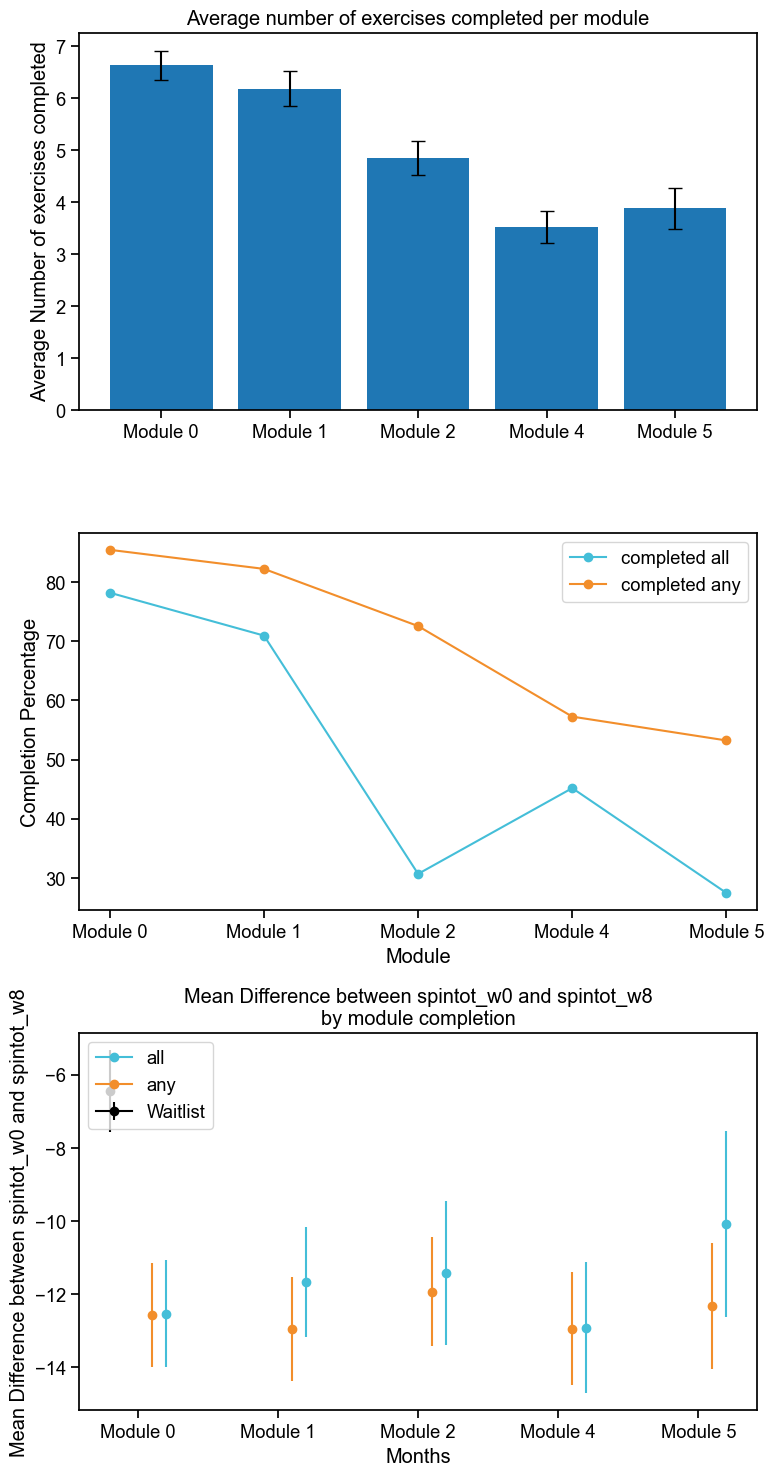

0      0
1      0
2      1
3      1
4      0
      ..
244    0
245    0
246    0
247    0
248    0
Name: sex_binary, Length: 124, dtype: int64



########################
Regression module containing module completion for module 0

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     4.344
Date:                Thu, 22 Jun 2023   Prob (F-statistic):            0.00282
Time:                        10:49:18   Log-Likelihood:                -407.97
No. Observations:                 103   AIC:                             825.9
Df Residuals:                      98   BIC:                             839.1
Df Model:                           4                                         
Covariance Type:            nonrobust                    

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Completed each exercise in a module at least once
completed_all_exercises = ['M0_completed', 'M1_completed', 'M2_completed', 'M4_completed', 'M5_completed']
completed_any_exercise = ['M0_any', 'M1_any', 'M2_any', 'M4_any', 'M5_any']
average_number_of_completions = ['total_M0', 'total_M1', 'total_M2', 'total_M4', 'total_M5']
axislabel = ['Module 0', 'Module 1', 'Module 2', 'Module 4', 'Module 5']
# Calculate the average and SEM of the columns for Intervention group
average_values = intervention_group[average_number_of_completions].mean()
sem_values = intervention_group[average_number_of_completions].sem()

# Calculate the percentage of users who completed at least one exercise at each time point
completed_percentages = (intervention_group[completed_all_exercises] > 0).mean() * 100
any_percentages = (intervention_group[completed_any_exercise] > 0).mean() * 100

# Create a figure with two subplots: one for average adherence with SEM, and one for completed percentages
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 15))

# Plot average adherence with SEM on ax1
ax1.bar(average_values.index, average_values.values, yerr=sem_values.values, capsize=5)
ax1.set_ylabel('Average Number of exercises completed')
ax1.set_title('Average number of exercises completed per module')
ax1.set_ylim(0)
ax1.set_xticklabels(axislabel) # Set xtick labels to 'group' values with rotation

x = list(range(1, len(completed_percentages)+1))
ax2.plot(x, completed_percentages, marker='o', color='#44bed8', label='completed all')
ax2.plot(x, any_percentages, marker='o', color='#f28e2b', label='completed any')
ax2.set_xticks(x)
ax2.set_xticklabels(axislabel)
ax2.set_xlabel('Module')
ax2.set_ylabel('Completion Percentage')
ax2.legend()

# Customize the appearance of the plots
plt.subplots_adjust(hspace=0.3)  # Adjust the vertical spacing between subplots

columns_of_interest= []
# Iterate over the weeks and perform the calculations
for week in range(1, 10):  # List of weeks to check
    column_name = "spintot_w" + str(week)
    
    if column_name in df.columns:
        columns_of_interest.append(column_name)

# Calculate the difference between 'spintot_w0' and the last spin value that was collected
difference_values = intervention_group[columns_of_interest[-1]] - intervention_group['spintot_w0']
diff_waitlist = waitlist_group[columns_of_interest[-1]] - waitlist_group['spintot_w0']
mean_waitlist = diff_waitlist[waitlist_group.index].mean()
std_waitlist = diff_waitlist[waitlist_group.index].sem()
ax3.errorbar(-0.2, mean_waitlist, yerr=std_waitlist, marker='o', label='Waitlist', color="k", mec="k")
    
# Loop through columns_to_average
for i, column in enumerate(completed_all_exercises):

    # Calculate the mean of difference_values for users with intervention_adherence[column] > 0
    mean_difference_all = difference_values[intervention_group.index][intervention_group[column] > 0].mean()

    # Calculate the mean of difference_values for users with intervention_adherence[column] > 0
    mean_difference_any = difference_values[intervention_group.index][intervention_group[completed_any_exercise[i]] > 0].mean()

#     # Calculate the mean of difference_values for users with intervention_adherence[column] == 0
#     mean_difference_zero = difference_values[intervention_group.index][intervention_group[column] == 0].mean()
    

    # Calculate standard deviation of difference_values for users with intervention_adherence[column] > 0
    std_difference_all = difference_values[intervention_group.index][intervention_group[column] > 0].sem()

    # Calculate the mean of difference_values for users with intervention_adherence[column] > 0
    std_difference_any = difference_values[intervention_group.index][intervention_group[completed_any_exercise[i]] > 0].sem()

#     # Calculate standard deviation of difference_values for users with intervention_adherence[column] == 0
#     std_difference_zero = difference_values[intervention_group.index][intervention_group[column] == 0].sem()
   

    ax3.errorbar(i+0.2, mean_difference_all, yerr=std_difference_all, marker='o', color="#44bed8", mec="#44bed8")
    ax3.errorbar(i+0.1, mean_difference_any, yerr=std_difference_any, marker='o', color="#f28e2b", mec="#f28e2b")
#     ax3.errorbar(i, mean_difference_zero, yerr=std_difference_zero, marker='o', color="#f42831", mec="#f42831")
    
    ax3.set_xlabel('Months')
    ax3.set_ylabel('Mean Difference between spintot_w0 and ' + columns_of_interest[-1])
    ax3.set_title('Mean Difference between spintot_w0 and ' + columns_of_interest[-1] + '\nby module completion')
    ax3.set_xticks(range(0,5)) # Set xticks to match index of intervention_adherence DataFrame
    ax3.set_xticklabels(axislabel) # Set xtick labels to 'group' values with rotation

ax3.plot([], [], color="#44bed8", marker='o', label='all')
ax3.plot([], [], color="#f28e2b", marker='o', label='any')
# ax3.plot([], [], color="#f42831", marker='o', label='none')
ax3.legend(loc='upper left')


# Show the plot
plt.tight_layout()
plt.show()

intervention_group['sex_binary']=[1 if x=='Male' else 0 for x in intervention_group['sex']]
print(intervention_group['sex_binary'])

# Is module completion related to change in SPIN when controlling for spin at time 0 and age
# which module
for i in [0,1,2,4,5]:
    toadd = 'M'+str(i)+'_any'
    regressors = ['age','sex_binary', 'spintot_w0', toadd]

    X = sm.add_constant(intervention_group[regressors])
    y = intervention_group[columns_of_interest[-1]] - intervention_group['spintot_w0']

    result = sm.OLS(y, X, missing='drop').fit()
    print('\n\n\n########################\nRegression module containing module completion for module '+str(i)+'\n')
    print (result.summary())

X = sm.add_constant(intervention_group[completed_any_exercise + ['age','sex_binary', 'spintot_w0']])
y = intervention_group[columns_of_interest[-1]] - intervention_group['spintot_w0']

result = sm.OLS(y, X, missing='drop').fit()

print('\n\n\n########################\nRegression module containing module completion for all models\n')
print (result.summary())



<Figure size 900x1500 with 0 Axes>

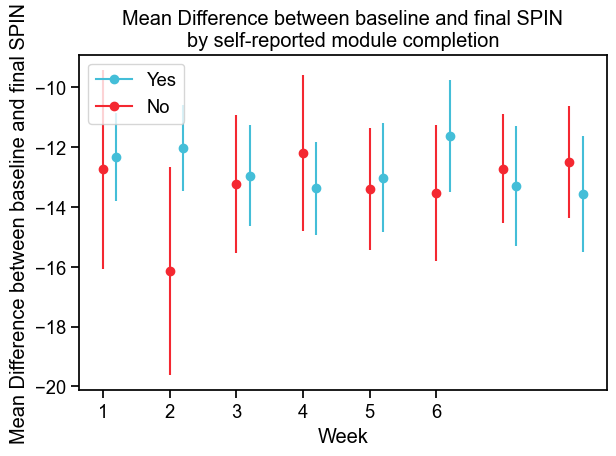

In [59]:

title = 'Reported exercise completion (questionnaire)\n'
variables = ['end_original_w']
order = {'end_original_w': ['Yes','No']}

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,15))

columns_of_interest = []
# Iterate over the weeks and perform the calculations
for week in range(0, 10):  # List of weeks to check
    column_name = "end_original_w" + str(week)
    
    if column_name in df.columns:
        columns_of_interest.append(column_name)
        

# Create a figure with two subplots: one for average adherence with SEM, and one for completed percentages
fig, ax3 = plt.subplots()

# Loop through columns_to_average
for i, column in enumerate(columns_of_interest):

    # Calculate the mean of difference_values for users with intervention_adherence[column] > 0
    mean_difference_all = difference_values[intervention_group[column] == 'Yes'].mean()

    # Calculate the mean of difference_values for users with intervention_adherence[column] == 0
    mean_difference_zero = difference_values[intervention_group[column] == 'No'].mean()
    

    # Calculate standard deviation of difference_values for users with intervention_adherence[column] > 0
    std_difference_all = difference_values[intervention_group[column] == 'Yes'].sem()

    # Calculate standard deviation of difference_values for users with intervention_adherence[column] == 0
    std_difference_zero = difference_values[intervention_group[column] == 'No'].sem()
   

    ax3.errorbar(i+1.2, mean_difference_all, yerr=std_difference_all, marker='o', color="#44bed8", mec="#44bed8")
    ax3.errorbar(i+1, mean_difference_zero, yerr=std_difference_zero, marker='o', color="#f42831", mec="#f42831")
    
    ax3.set_xlabel('Week')
    ax3.set_ylabel('Mean Difference between baseline and ' + 'final SPIN')
    ax3.set_title('Mean Difference between baseline and ' + 'final SPIN\nby self-reported module completion')
    ax3.set_xticks(range(0,7)) # Set xticks to match index of intervention_adherence DataFrame
    
ax3.plot([], [], color="#44bed8", marker='o', label='Yes')
ax3.plot([], [], color="#f42831", marker='o', label='No')
ax3.legend(loc='upper left')


# Show the plot
plt.tight_layout()
plt.show()



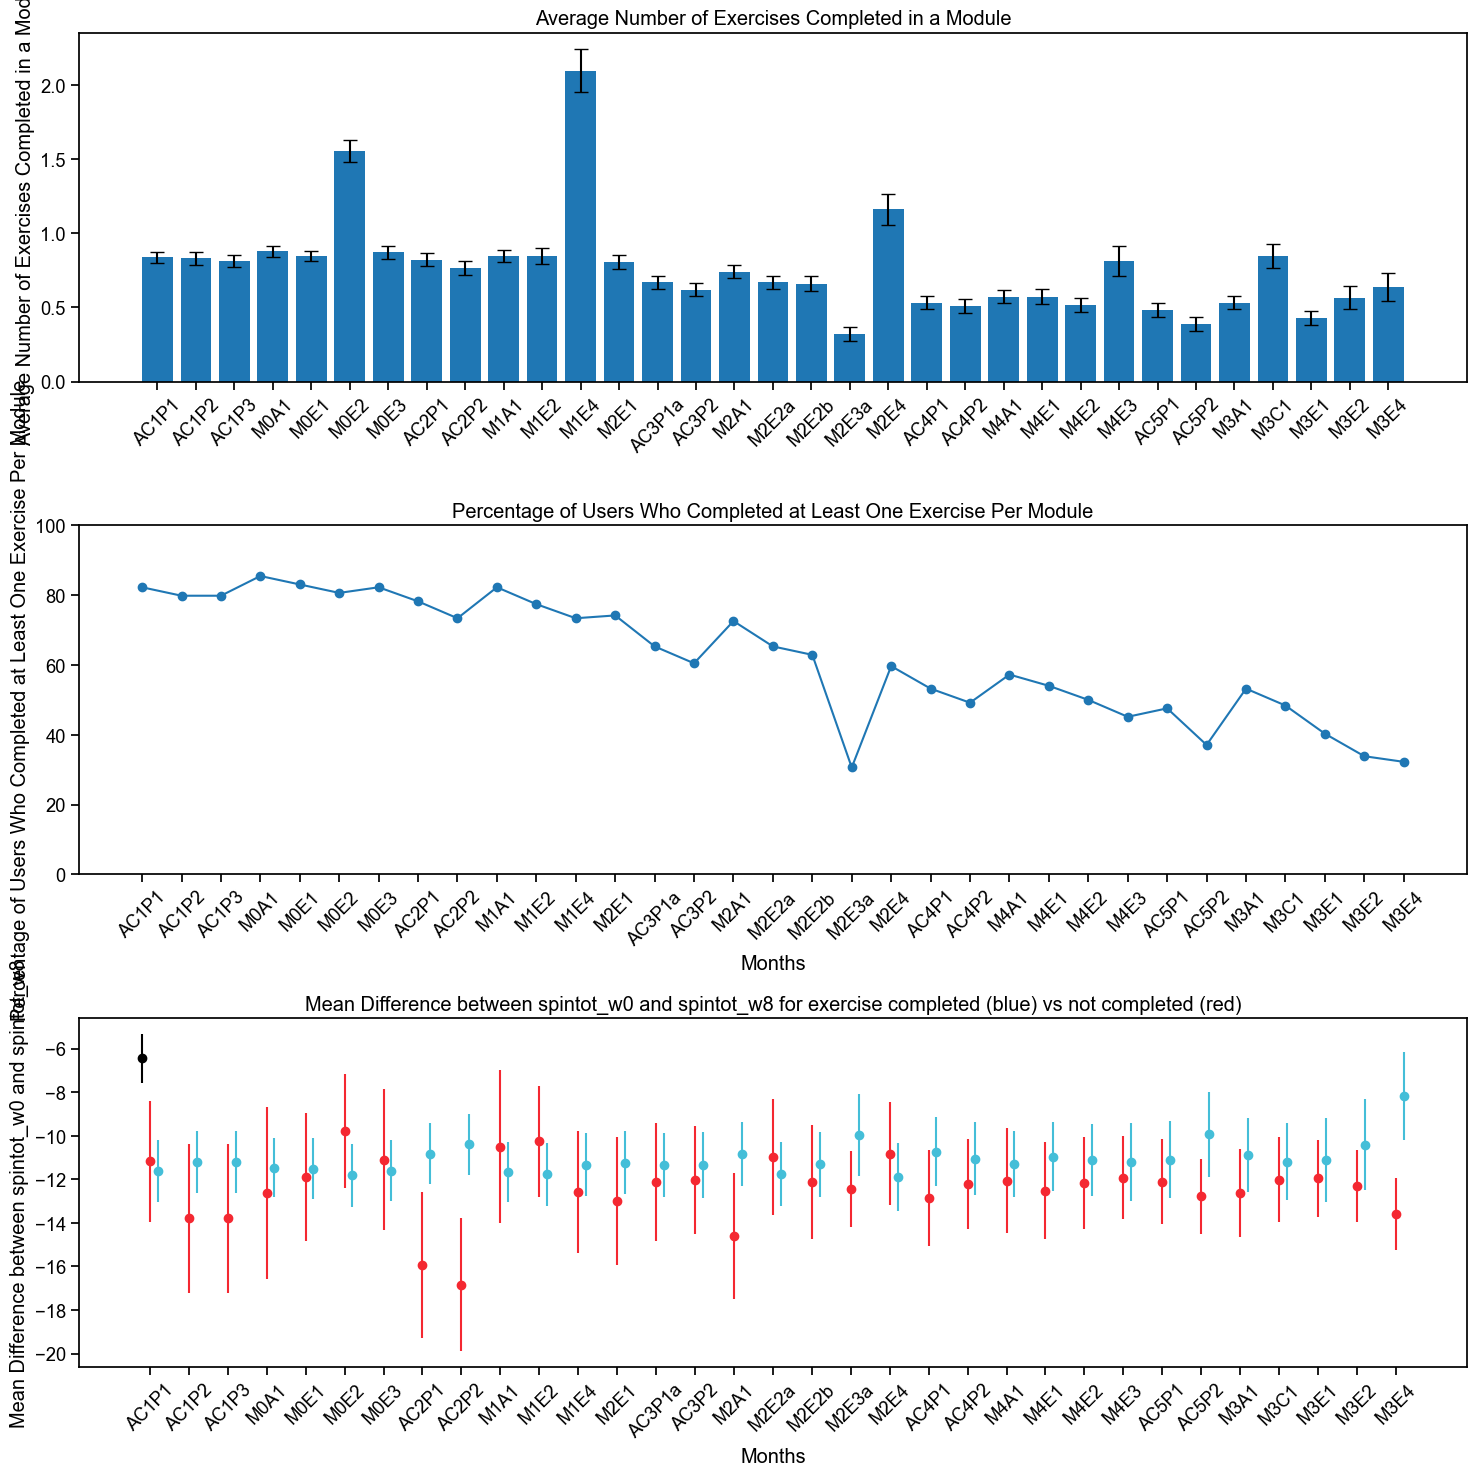

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Columns to calculate average and SEM
columns_to_average = ['AC1P1', 'AC1P2', 'AC1P3', 'M0A1', 'M0E1', 'M0E2', 'M0E3',
                    'AC2P1', 'AC2P2', 'M1A1', 'M1E2', 'M1E4', 'M2E1', 
                    'AC3P1a', 'AC3P2', 'M2A1', 'M2E2a', 'M2E2b', 'M2E3a', 'M2E4', 
                    'AC4P1', 'AC4P2', 'M4A1', 'M4E1', 'M4E2', 'M4E3', 
                    'AC5P1', 'AC5P2', 'M3A1', 'M3C1', 'M3E1', 'M3E2', 'M3E4']

# Calculate the average and SEM of the columns for Intervention group
average_values = intervention_group[columns_to_average].mean()
sem_values = intervention_group[columns_to_average].sem()

# Calculate the percentage of users who completed at least one exercise at each time point
completed_percentages = (intervention_group[columns_to_average] > 0).mean() * 100

# Create a figure with three subplots: one for average adherence with SEM, one for completed percentages, and one for the difference between 'spintot_w0' and 'spintot_w2'
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

# Plot average adherence with SEM on ax1
ax1.bar(average_values.index, average_values.values, yerr=sem_values.values, capsize=5)
ax1.set_ylabel('Average Number of Exercises Completed in a Module')
ax1.set_title('Average Number of Exercises Completed in a Module')
ax1.set_ylim(0)
ax1.set_xticklabels(columns_to_average, rotation=45) # Set xtick labels to 'group' values with rotation

# Plot completed percentages on ax2
ax2.plot(completed_percentages.index, completed_percentages.values, marker='o')
ax2.set_xlabel('Months')
ax2.set_ylabel('Percentage of Users Who Completed at Least One Exercise Per Module')
ax2.set_title('Percentage of Users Who Completed at Least One Exercise Per Module')
ax2.set_ylim(0, 100)
ax2.set_xticklabels(columns_to_average, rotation=45) # Set xtick labels to 'group' values with rotation

completed_percentages = (intervention_group[columns_to_average] > 0).mean() * 100

columns_of_interest= []
# Iterate over the weeks and perform the calculations
for week in range(1, 10):  # List of weeks to check
    column_name = "spintot_w" + str(week)
    
    if column_name in df.columns:
        columns_of_interest.append(column_name)

# Calculate the difference between 'spintot_w0' and the last spin value that was collected
difference_values = intervention_group[columns_of_interest[-2]] - intervention_group['spintot_w0']
ax3.errorbar(-0.2, mean_waitlist, yerr=std_waitlist, marker='o', label='Waitlist', color="k", mec="k")

# Loop through columns_to_average
for i, column in enumerate(columns_to_average):
    # Calculate the mean of difference_values for users with intervention_adherence[column] > 0
    mean_difference_positive = difference_values[intervention_group.index][intervention_group[column] > 0].mean()
    # Calculate the mean of difference_values for users with intervention_adherence[column] == 0
    mean_difference_zero = difference_values[intervention_group.index][intervention_group[column] == 0].mean()

    # Calculate standard deviation of difference_values for users with intervention_adherence[column] > 0
    std_difference_positive = difference_values[intervention_group.index][intervention_group[column] > 0].sem()
    # Calculate standard deviation of difference_values for users with intervention_adherence[column] == 0
    std_difference_zero = difference_values[intervention_group.index][intervention_group[column] == 0].sem()

    ax3.errorbar(i, mean_difference_zero, yerr=std_difference_zero, marker='o', label=f'{column} == 0', color="#f42831", mec="#f42831")
    ax3.errorbar(i+0.2, mean_difference_positive, yerr=std_difference_positive, marker='o', label=f'{column} > 0', color="#44bed8", mec="#44bed8")
    
    ax3.set_xlabel('Months')
    ax3.set_ylabel('Mean Difference between spintot_w0 and ' + columns_of_interest[-1])
    ax3.set_title('Mean Difference between spintot_w0 and ' + columns_of_interest[-1] + ' for exercise completed (blue) vs not completed (red)')
    ax3.set_xticks(range(0,len(columns_to_average))) # Set xticks to match index of intervention_adherence DataFrame
    ax3.set_xticklabels(columns_to_average, rotation=45) # Set xtick labels to 'group' values with rotation

plt.tight_layout()
plt.show()


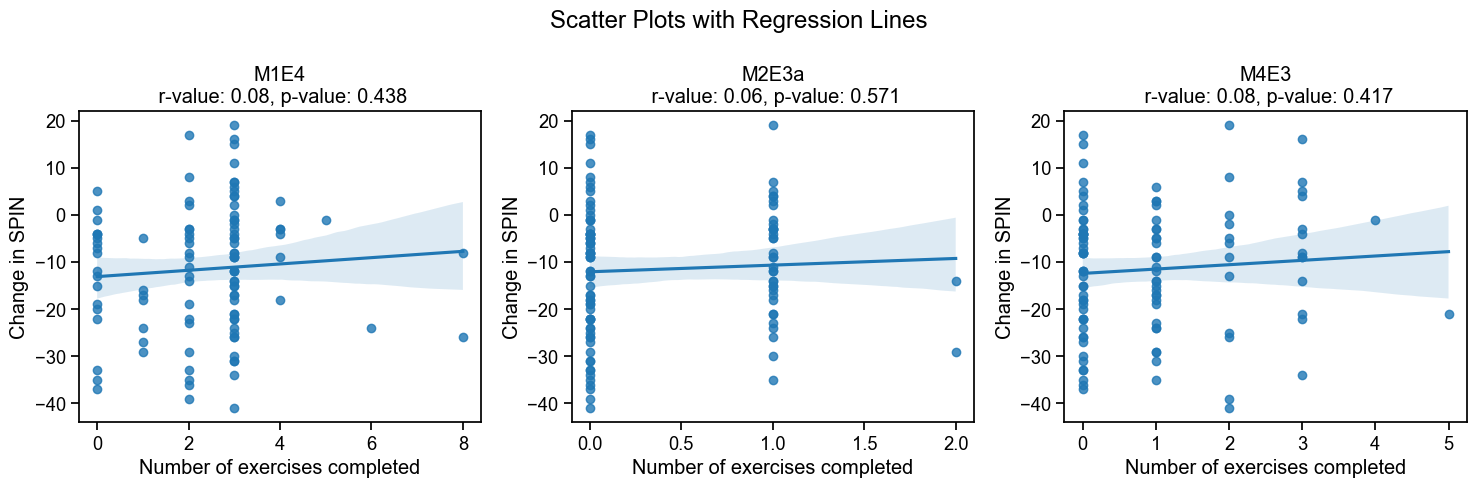

In [61]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Columns to calculate average and SEM
columns_to_average = ['M1E4','M2E3a','M4E3']

# Create a figure with subplots for each column
fig, axs = plt.subplots(1, len(columns_to_average), figsize=(15, 5))

# Iterate over each column, create a scatter plot with regression line
for i, column in enumerate(columns_to_average):
    xvalues = intervention_group[column]
    yvalues = difference_values
    data = pd.concat([xvalues, yvalues], axis=1)
    data.dropna(inplace=True)

    # Calculate the regression statistics
    x_values = data.iloc[:, 0]
    y_values = data.iloc[:, 1]
    slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

    # Use sns.regplot to create the scatter plot with regression line
    sns.regplot(x=x_values, y=y_values, ax=axs[i])
    axs[i].set_title(f'{column}\n r-value: {r_value:.2f}, p-value: {p_value:.3f}')

    axs[i].set_xlabel(f'Number of exercises completed')
    axs[i].set_ylabel('Change in SPIN')

# Set the title for the entire figure
fig.suptitle('Scatter Plots with Regression Lines')

# Adjust spacing between subplots
fig.tight_layout()





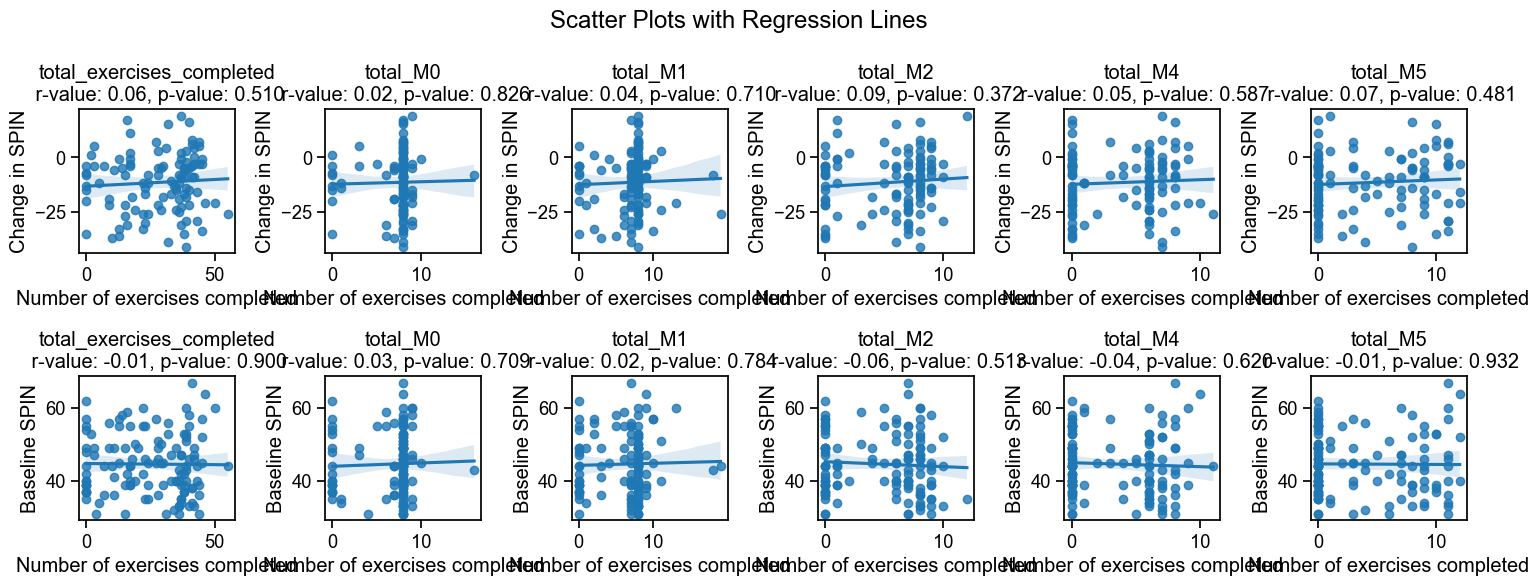

In [62]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Columns to calculate average and SEM
columns_to_average = ['total_exercises_completed','total_M0', 'total_M1', 'total_M2', 'total_M4', 'total_M5']

# Create a figure with subplots for each column
fig, axs = plt.subplots(2, len(columns_to_average), figsize=(15, 6))

# Iterate over each column, create a scatter plot with regression line
for i, column in enumerate(columns_to_average):
    xvalues = intervention_group[column]
    yvalues = difference_values
    data = pd.concat([xvalues, yvalues], axis=1)
    data.dropna(inplace=True)

    # Calculate the regression statistics
    x_values = data.iloc[:, 0]
    y_values = data.iloc[:, 1]
    slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

    # Use sns.regplot to create the scatter plot with regression line
    sns.regplot(x=x_values, y=y_values, ax=axs[0,i])
    axs[0,i].set_title(f'{column}\n r-value: {r_value:.2f}, p-value: {p_value:.3f}')

    axs[0,i].set_xlabel(f'Number of exercises completed')
    axs[0,i].set_ylabel('Change in SPIN')


    xvalues = intervention_group[column]
    yvalues = intervention_group['spintot_w0']
    data = pd.concat([xvalues, yvalues], axis=1)
    data.dropna(inplace=True)

    # Calculate the regression statistics
    x_values = data.iloc[:, 0]
    y_values = data.iloc[:, 1]
    slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

    # Use sns.regplot to create the scatter plot with regression line
    sns.regplot(x=x_values, y=y_values, ax=axs[1,i])
    axs[1,i].set_title(f'{column}\n r-value: {r_value:.2f}, p-value: {p_value:.3f}')

    axs[1,i].set_xlabel(f'Number of exercises completed')
    axs[1,i].set_ylabel('Baseline SPIN')

# Set the title for the entire figure
fig.suptitle('Scatter Plots with Regression Lines')

# Adjust spacing between subplots
fig.tight_layout()


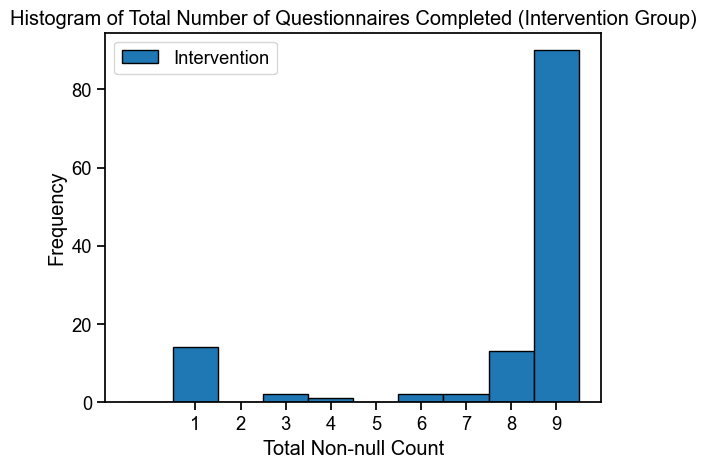

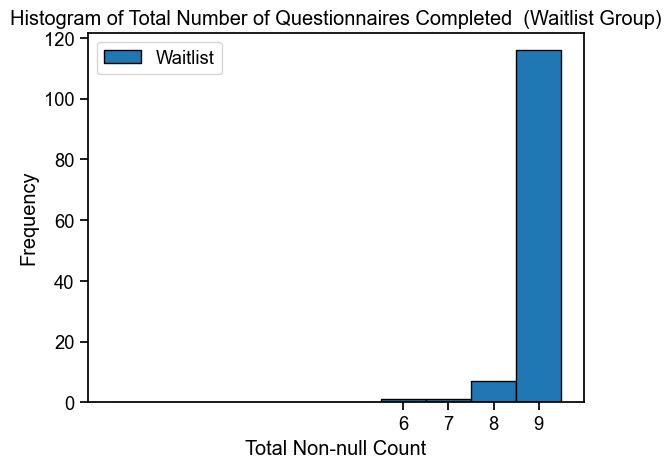

Age:
Intervention mean, std: 39.52, 10.71
Waitlist mean, std: 38.02, 10.82
t: nan, p: nan


Sex:
group   Intervention  Waitlist
sex                           
Female            56        77
Male              32        39
chi2 =  0.06705320190404943
p =  0.7956766506532632

Ethnicity:
group                         Intervention  Waitlist
eth_original                                        
Any other ethnic group                   2         2
Asian/Asian British                      5         6
Black/Black British                      5         1
Mixed/Multiple ethnic groups             3         3
White/White British                     75       104
chi2 =  4.241919613524313
p =  0.3742545036788434

Employment:
group                                               Intervention  Waitlist
employ_original                                                           
Retired                                                        1         2
Student                                                 

In [63]:
df = pd.read_csv(dir + 'preprocessed_data/merged.csv', delimiter=',', error_bad_lines=False)

# Filter columns based on column names pattern
relevant_cols = df.filter(regex='spintot_w[0-9]').columns

# Calculate total count of non-null values across relevant columns
df['total_questionnaire_completed'] = df[relevant_cols].count(axis=1)



# Filter DataFrame for 'Intervention' group
df_intervention = df[df['group'] == 'Intervention']

# Filter DataFrame for 'Waitlist' group
df_waitlist = df[df['group'] == 'Waitlist']

# Plot histogram of 'total_non_null_count' for 'Intervention' group
plt.hist(df_intervention['total_questionnaire_completed'].dropna(), bins=range(0, df_intervention['total_questionnaire_completed'].max() + 2), edgecolor='black', align='left', label='Intervention')
plt.xlabel('Total Non-null Count')
plt.ylabel('Frequency')
plt.title('Histogram of Total Number of Questionnaires Completed (Intervention Group)')
plt.legend()
plt.xticks(np.arange(df_intervention['total_questionnaire_completed'].min(), df_intervention['total_questionnaire_completed'].max()+1, 1))

plt.show()

# Plot histogram of 'total_non_null_count' for 'Waitlist' group
plt.hist(df_waitlist['total_questionnaire_completed'].dropna(), bins=range(0, df_waitlist['total_questionnaire_completed'].max() + 2), edgecolor='black', align='left', label='Waitlist')
plt.xlabel('Total Non-null Count')
plt.ylabel('Frequency')
plt.title('Histogram of Total Number of Questionnaires Completed  (Waitlist Group)')
plt.legend()
plt.xticks(np.arange(df_waitlist['total_questionnaire_completed'].min(), df_waitlist['total_questionnaire_completed'].max()+1, 1))

plt.show()

df = df.drop(df[df['total_questionnaire_completed'] < max(df['total_questionnaire_completed'])].index)


print('Age:')
t, p = stats.ttest_ind(df['age'][df['group'] == 'Waitlist'], df['age'][df['group'] == 'Intervention'])
intervention_mean = df['age'][df['group'] == 'Intervention'].mean()
intervention_std = df['age'][df['group'] == 'Intervention'].std()
waitlist_mean = df['age'][df['group'] == 'Waitlist'].mean()
waitlist_std = df['age'][df['group'] == 'Waitlist'].std()
print('Intervention mean, std: {:.2f}, {:.2f}'.format(intervention_mean, intervention_std))
print('Waitlist mean, std: {:.2f}, {:.2f}'.format(waitlist_mean, waitlist_std))
print('t: {:.2f}, p: {:.2f}\n'.format(t, p))

print('\nSex:')
observations = pd.crosstab(index=df["sex"], columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print(observations)
print("chi2 = ", chi2)
print("p = ", p)

print('\nEthnicity:')
observations = pd.crosstab(index=df["eth_original"], columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print(observations)
print("chi2 = ", chi2)
print("p = ", p)

print('\nEmployment:')
observations = pd.crosstab(index=df["employ_original"], columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print(observations)
print("chi2 = ", chi2)
print("p = ", p)

print('\nEducation:')
observations = pd.crosstab(index=df["edu_original"], columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print(observations)
print("chi2 = ", chi2)
print("p = ", p)

print('\nPrevious app use:')
observations = pd.crosstab(index=df["apps_original"], columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print(observations)
print("chi2 = ", chi2)
print("p = ", p)

print('\nPrevious therapy experience experience:')
observations = pd.crosstab(index=df["thpy_original"], columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print(observations)
print("chi2 = ", chi2)
print("p = ", p)

print('\nSPIN at baseline:')
t, p = stats.ttest_ind(df['spintot_w0'][df['group'] == 'Waitlist'], df['spintot_w0'][df['group'] == 'Intervention'])
intervention_mean = df['spintot_w0'][df['group'] == 'Intervention'].mean()
intervention_std = df['spintot_w0'][df['group'] == 'Intervention'].std()
waitlist_mean = df['spintot_w0'][df['group'] == 'Waitlist'].mean()
waitlist_std = df['spintot_w0'][df['group'] == 'Waitlist'].std()
print('Intervention mean, std: {:.2f}, {:.2f}'.format(intervention_mean, intervention_std))
print('Waitlist mean, std: {:.2f}, {:.2f}'.format(waitlist_mean, waitlist_std))
print('t: {:.2f}, p: {:.2f}\n'.format(t, p))

print('\nExpectation:')
observations = pd.crosstab(index=df["expect_original"], columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print(observations)
print("chi2 = ", chi2)
print("p = ", p)

plt.style.use('default')
plt.rcParams.update({'font.family':'sans-serif'})
plt.rcParams.update({'font.sans-serif':'Arial'})
plt.rcParams.update({'font.size': 8})


print('\nEthnicity:')
observations = pd.crosstab(index=df["eth_original"], columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print(observations)
print("chi2 = ", chi2)
print("p = ", p)



print('\nApp versions:')
observations = pd.crosstab(index=df["app_version"], columns=df["group"], margins=False)
print(observations)

